In [10]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'

import pandas as pd
import numpy as np

import glob
import re
import seaborn as sns
import statsmodels.api as sm
import statsmodels
import scipy
from scipy import signal
import nideconv
from nideconv import GroupResponseFitter

import pickle as pkl
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [11]:
def merge_events_regressors(events, regressors, 
                            on_stimulus=('value_chosen', 'value_unchosen', 'value_high', 'value_low', 'outcome', 'value_difference'),
                            on_feedback=('value_chosen', 'outcome'),
                            zscore=(),
                            demean=(), rescale_values=False):
    ''' merge 'events' df (with onsets trial types) with trial-wise 'regressors' df, which contains the covariates '''
    ''' what to do with demeaning'''
    
    # Put values on same scale as outcome?
    if rescale_values:
        max_value = regressors[['value_high', 'value_low']].max().max()
        regressors['value_high'] /= max_value
        regressors['value_low'] /= max_value
        regressors['value_chosen'] /= max_value
        regressors['value_unchosen'] /= max_value
    
    if 'rt' in on_stimulus:
        # extract response time from events, add to trial-wise regressors
        tmp = events.pivot_table(values='onset', index='trial_nr', columns='trial_type')
        tmp['response_onset'] = tmp[['response_left', 'response_right']].apply(lambda x: np.nansum(x), axis=1)
        tmp.loc[(pd.isnull(tmp.response_left) & pd.isnull(tmp.response_right)), 'response_onset'] = np.nan
        tmp['rt'] = tmp['response_onset'] - tmp['stimulus']
        regressors = pd.merge(regressors, tmp.reset_index()[['trial_nr', 'rt']], how='outer')
    if 'value_difference' in on_stimulus:
        if 'Q_value_difference' in regressors.columns:   # EMC2-derived PEs and Q-values
            regressors['value_difference'] = regressors['Q_value_difference']
        else:                                            # DMC-derived PEs and Q-values
            regressors['value_difference'] = regressors['value_high'] - regressors['value_low']

            
    # z-score regressors that need to be z-scored
    if len(zscore)>0:
        for regressor_name in zscore:
            regressors[[regressor_name]] = regressors[[regressor_name]].apply(lambda x: (x-x.mean())/x.std())
    
    if len(demean)>0:
        for regressor_name in demean:
            regressors[[regressor_name]] = regressors[[regressor_name]].apply(lambda x: (x-x.mean()))
    ## 
    if len(on_stimulus) > 0:
        regressors_on_stimulus = regressors.melt(id_vars='trial_nr', 
                                                 value_vars=on_stimulus).rename(columns={'variable':'trial_type', 'value': 'modulation'})
        regressors_on_stimulus['trial_type2'] = 'stimulus'
    
    if len(on_feedback) > 0:
        regressors_on_feedback = regressors.melt(id_vars='trial_nr', 
                                                 value_vars=on_feedback).rename(columns={'variable':'trial_type', 'value': 'modulation'})
        regressors_on_feedback['trial_type2'] = 'feedback'


    # merge with events
    to_concat = [events]
    if len(on_stimulus) > 0:
        tmp_stimulus_regressors = pd.merge(events, regressors_on_stimulus, left_on=['trial_nr', 'trial_type'], right_on=['trial_nr', 'trial_type2']).rename(columns={'trial_type_y':'trial_type'})
        tmp_stimulus_regressors['trial_type'] = tmp_stimulus_regressors['trial_type'].apply(lambda x: 'stimulus_'+x)
        to_concat.append(tmp_stimulus_regressors[['trial_nr', 'onset', 'trial_type', 'duration', 'modulation']])
    if len(on_feedback) > 0:
        tmp_feedback_regressors = pd.merge(events, regressors_on_feedback, left_on=['trial_nr', 'trial_type'], right_on=['trial_nr', 'trial_type2']).rename(columns={'trial_type_y':'trial_type'})
        tmp_feedback_regressors['trial_type'] = tmp_feedback_regressors['trial_type'].apply(lambda x: 'feedback_'+x)
        to_concat.append(tmp_feedback_regressors[['trial_nr', 'onset', 'trial_type', 'duration', 'modulation']])
    
    # Merge
    events = pd.concat(objs=to_concat, axis=0).sort_values('onset').reset_index(drop=True)
    
    #events['duration'] = 0.001
    events = events.loc[~(events.trial_type.isin(list(on_stimulus)+list(on_feedback)) & pd.isnull(events.modulation))]    
    events['modulation'] = events['modulation'].fillna(1)
#    display(events)
    return events


def make_events_this_model(events, regressors, model_n):
    ### Create events corresponding to this model's design matrix
    rescale_values = False
    
    if model_n == '0a-z':
        on_stimulus=('value_difference',)
        on_feedback=('PE',)
        zscore = ('value_difference', 'PE')
        demean = ()
    elif model_n == '0a-dm-RTdur':
        on_stimulus=('value_difference', 'rt')
        on_feedback=('PE',)
        zscore = ()
        demean = ('value_difference', 'PE')

    events = merge_events_regressors(events, regressors, on_stimulus=on_stimulus, on_feedback=on_feedback, 
                                     zscore=zscore, demean=demean, rescale_values=rescale_values)[['onset', 'trial_type', 'duration', 'modulation', 'trial_nr']]
    
    return events

def load_events_confounds(sub, ses, task, run, model_n='0a-z', include_physio=True, include_cosines=True):
    event_fn = f'../derivatives/event_files/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_events.tsv'
    regressor_fn = f'../derivatives/behavior/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-model-regressors-emc2.tsv'
    confounds_fn = f'../derivatives/fmriprep/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-confounds_timeseries.tsv'
    
    events = pd.read_csv(event_fn, sep='\t', index_col=None)
    regressors  = pd.read_csv(regressor_fn, sep='\t')
    events = make_events_this_model(events, regressors, model_n)
    
    # get confounds, cosines
    confounds = pd.read_csv(confounds_fn, sep='\t').fillna(method='bfill')
    include_confs = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'dvars', 'framewise_displacement']
    if include_cosines:
        include_confs += [x for x in confounds.columns if 'cos' in x]
    confounds = confounds[include_confs]
    
    if include_physio:
        run_idx = run#+1
        retroicor_fn = f'../derivatives/retroicor/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run_idx}_desc-retroicor_regressors.tsv'
        if not os.path.exists(retroicor_fn):
            ## take first 20 aCompCor components
            print(f"{sub} {run} No retroicor found, including 20 a_comp_cor components. Renaming them as if they are from RETROICOR for ease later on, BUT BE CAREFUL")
            a_comp_cor = pd.read_csv(confounds_fn, sep='\t')[['a_comp_cor_' + str(x).zfill(2) for x in range(20)]]
            a_comp_cor.columns = ['cardiac_' + str(x) for x in range(6)] + ['respiratory_' + str(x) for x in range(8)] + ['respiratoryxcardiac_' + str(x) for x in range(4)] + ['HRV', 'RVT']
            confounds = pd.concat([confounds, a_comp_cor], axis=1)
        else:
            retroicor = pd.read_csv(retroicor_fn, sep='\t', header=None).iloc[:,:20]  ## 20 components in total
            retroicor.columns = ['cardiac_' + str(x) for x in range(6)] + ['respiratory_' + str(x) for x in range(8)] + ['respiratoryxcardiac_' + str(x) for x in range(4)] + ['HRV', 'RVT']
            confounds = pd.concat(objs=[confounds, retroicor], axis=1)

    return events, confounds

In [12]:
def to_psc(x):
    return x / x.mean() * 100 - 100

In [13]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [16]:
## Load timeseries
atlas_type = ['MASSP', 'THAL', 'MASSP2p0'][-1]
signal_fns = sorted(glob.glob(f'../derivatives/extracted_signals/sub-*/ses-rlsat/func/*task-rlsat*{atlas_type}*.tsv'))
signal_fns

filter_out_confounds = False
filter_hp = False

excluded_runs = []

regex = re.compile(f'.*sub-(?P<sub>\d+)_ses-rlsat_task-rlsat_run-(?P<run>\d)_desc-{atlas_type}-signals.tsv')
dfs = []
# confoundss = []
for signal_fn in signal_fns:
    signals = pd.read_csv(signal_fn, sep='\t')
    gd = regex.match(signal_fn).groupdict()
    if tuple(gd.values()) in excluded_runs:
        # run was excluded
        continue
    
    if 'time' in signals.columns:
        # if there's a column named 'time', it's called 'time' but it's really volume number..
        signals = signals.rename(columns={'time': 'volume'})
    signals = signals.set_index('volume')
    
    # psc?
    signals = signals.apply(to_psc)  # to PSC    
    
    signals = signals.fillna(0)

    # filter out confounds?
    _, confounds = load_events_confounds(sub=gd['sub'], ses='rlsat', task='rlsat', run=gd['run'])
    # confounds['subject'] = gd['sub']
    # confounds['run'] = int(gd['run'])
    # confoundss.append(confounds)
    if filter_out_confounds:
        confounds['intercept'] = 1   # add intercept!
        betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals, rcond=None)
        signals_hat = confounds@betas
        signals_hat.index = signals.index
        signals_hat.columns = signals.columns
        signals -= signals_hat   # residuals
        
    # high pass?
    if filter_hp:
        signals = signals.apply(lambda x: butter_highpass_filter(x, cutoff=1/128, fs=1/1.38) + x.mean(), axis=0)
    
    # index to time
    signals.index *= 1.38
    signals.index.name = 'time'
    signals['subject'] = gd['sub']
    signals['run'] = int(gd['run'])

    signals = signals.reset_index().set_index(['subject', 'run', 'time'])
    dfs.append(signals)
df = pd.concat(dfs)
df.head()


010 2 No retroicor found, including 20 a_comp_cor components. Renaming them as if they are from RETROICOR for ease later on, BUT BE CAREFUL
010 3 No retroicor found, including 20 a_comp_cor components. Renaming them as if they are from RETROICOR for ease later on, BUT BE CAREFUL
018 3 No retroicor found, including 20 a_comp_cor components. Renaming them as if they are from RETROICOR for ease later on, BUT BE CAREFUL
044 1 No retroicor found, including 20 a_comp_cor components. Renaming them as if they are from RETROICOR for ease later on, BUT BE CAREFUL
044 2 No retroicor found, including 20 a_comp_cor components. Renaming them as if they are from RETROICOR for ease later on, BUT BE CAREFUL
044 3 No retroicor found, including 20 a_comp_cor components. Renaming them as if they are from RETROICOR for ease later on, BUT BE CAREFUL


3V        4V     AC-lr     Amg-l     Amg-r     Ca1-l  \
subject run time                                                               
002     1   0.00  4.376454  3.525522  0.692487  1.970790 -0.415693  2.310542   
            1.38  2.691923  2.990362  0.318929  1.610516 -0.042824  1.783259   
            2.76  3.597870  1.953802  0.192601  2.010314  0.197373  1.637003   
            4.14  3.502508  2.188940  0.305379  1.931023 -0.413068  1.609758   
            5.52  2.523949  1.571524  0.403606  1.600747  0.334245  1.518438   

                     Ca1-r    Ca23-l    Ca23-r     Cau-l  ...      ic-l  \
subject run time                                          ...             
002     1   0.00  1.001186  2.076034  0.590383  0.118547  ...  0.663424   
            1.38  0.891031  1.212242  0.259713  0.068665  ...  0.373227   
            2.76  0.771933  1.318598  0.318584  0.091571  ...  0.428283   
            4.14  1.011366  1.402551  0.798118 -0.722815  ...  0.029440   
            5.52  0.841655  1.460254  0.417865 -0.321411  ...  0.406934   

                      ic-r    nAcc-l    nAcc-r  presub-l  presub-r     sub-l  \
subject run time                                                               
002     1   0.00  0.346186  1.848995  1.763857  5.418855  5.212833  2.000167   
            1.38  0.332514  1.572587  1.109827  3.160282  2.688128  1.441099   
            2.76  0.439392  1.900653  1.034589  0.449514  1.719579  1.187097   
            4.14  0.104249  1.125223  1.196869  2.238129  3.181435  1.573615   
            5.52  0.343559  1.762575  0.694617  4.002441  3.861000  1.030952   

                     sub-r     unc-l     unc-r  
subject run time                                
002     1   0.00  3.000391  3.809611  1.969963  
            1.38  3.038070  2.439304  2.056265  
            2.76  2.986301  2.442960  1.851806  
            4.14  2.705116  3.138806  2.399307  
            5.52  2.748584  2.416470  2.096690  

[5 rows x 63 columns]

## Load events and confounds data

In [15]:
model_n = '0a-dm-RTdur' #'0a-z'
all_events = []
all_confounds = []
all_CSF_WM_confounds = []

for sub, run in df.reset_index().set_index(['subject', 'run']).index.unique():
    events, confounds = load_events_confounds(sub, 'rlsat', 'rlsat', run, model_n=model_n, include_physio=True)
    events['subject'] = sub
    events['run'] = run
    confounds['subject'] = sub
    confounds['run'] = run
    
    confounds_fn = f'../derivatives/fmriprep/fmriprep/sub-{sub}/ses-rlsat/func/sub-{sub}_ses-rlsat_task-rlsat_run-{run}_desc-confounds_timeseries.tsv'
    csf_wm = pd.read_csv(confounds_fn, sep='\t')[['csf', 'white_matter']]
    ## to PSC
    csf_wm = csf_wm.apply(to_psc)
    csf_wm['subject'] = sub
    csf_wm['run'] = run
    all_CSF_WM_confounds.append(csf_wm)    
    all_events.append(events)
    all_confounds.append(confounds)
    
events = pd.concat(all_events).set_index(['subject', 'run'])
confounds = pd.concat(all_confounds).set_index(['subject', 'run'])
all_CSF_WM_confounds = pd.concat(all_CSF_WM_confounds).set_index(['subject', 'run'])

events = events.rename(columns={'trial_type': 'event_type'})


010 2 No retroicor found, including 20 a_comp_cor components. Renaming them as if they are from RETROICOR for ease later on, BUT BE CAREFUL
010 3 No retroicor found, including 20 a_comp_cor components. Renaming them as if they are from RETROICOR for ease later on, BUT BE CAREFUL
018 3 No retroicor found, including 20 a_comp_cor components. Renaming them as if they are from RETROICOR for ease later on, BUT BE CAREFUL


## Save for joint modelling

In [18]:
events.index = events.index.rename({'subject': 'subjects'})
events_to_save = events.rename(columns={'event_type': 'trial_type'})
events_to_save.to_csv('./joint_modelling_data_unfiltered/all_events_with_RT.tsv', sep='\t')
confounds.index = confounds.index.rename({'subject': 'subjects'})
all_CSF_WM_confounds.index = all_CSF_WM_confounds.index.rename({'subject': 'subjects'})
all_CSF_WM_confounds.to_csv('./joint_modelling_data_unfiltered/confounds_WM_CSF.tsv', sep='\t')
confounds.to_csv('./joint_modelling_data_unfiltered/confounds_OLS.tsv', sep='\t')

if atlas_type == 'MASSP':
    timeseries = df.copy()
    timeseries = timeseries[[x for x in timeseries.columns if x not in ['3V', '4V', 'ic-l', 'ic-r', 'fx', 'LV-l', 'LV-r']]]
    timeseries.index = timeseries.index.rename({'subject': 'subjects'})
    timeseries.to_csv('./joint_modelling_data_unfiltered/timeseries-massp-leftright.tsv', sep='\t')

    ## Collapse hemispheres for timeseries
    timeseries_long = timeseries.melt(ignore_index=False)
    timeseries_long['ROI_nohemi'] = timeseries_long['variable'].apply(lambda x: x.split('-')[0])
    timeseries_long['hemisphere'] = timeseries_long['variable'].apply(lambda x: x.split('-')[1])
    timeseries_long = timeseries_long.reset_index().groupby(['subjects', 'run', 'ROI_nohemi', 'time']).mean()
    timeseries_collapsed = timeseries_long.pivot_table(values='value', columns='ROI_nohemi', index=['subjects', 'run', 'time'])

    timeseries_collapsed.to_csv('./joint_modelling_data_unfiltered/timeseries-massp-collapsed.tsv', sep='\t')

    ## only basal ganglia
    bg = ['Str', 'GPi', 'GPe', 'SN', 'STN']
    lr = ['-l', '-r']
    bg_lr = [x+y for x in bg for y in lr]
    timeseries[bg_lr].to_csv('./joint_modelling_data_unfiltered/timeseries-massp-bg.tsv', sep='\t')

elif atlas_type == 'MASSP2p0':
    timeseries = df.copy()
    ## only save striatum
    str_ = ['Pu', 'Cau', 'nAcc']
    lr = ['-l', '-r']
    str_lr = [x+y for x in str_ for y in lr]
    timeseries.index = timeseries.index.rename({'subject': 'subjects'})
    timeseries[str_lr].to_csv('./joint_modelling_data_unfiltered/timeseries-massp2p0-str.tsv', sep='\t')

    
elif atlas_type == 'SATeffect':
    ## ONLY for SATeffect
    mask_dict = {'0': 'left_M1',
                 '2': 'left_insula',
                 '5': 'str.l',
                 '10': 'preSMA.lr',
                 '12': 'tha.lr',
                 '13': 'str.r',
                 '17': 'right_M1'
                }

    timeseries = df.copy()
    timeseries.columns = [mask_dict[x] if x in mask_dict.keys() else x for x in timeseries.columns]
    timeseries = timeseries[['preSMA.lr', 'tha.lr', 'str.r', 'str.l']]
    timeseries.index = timeseries.index.rename({'subject': 'subjects'})

    timeseries.to_csv('./joint_modelling_data_unfiltered/timeseries-sateffect.tsv', sep='\t')
    
elif atlas_type == 'THAL':
    timeseries = df.copy()
    rois = ['CM', 'MDl', 'MDm', 'PuM', 'VA', 'VLa', 'VLp', 'VPL']
    lr = ['-l', '-r']
    rois_lr = [x+y for x in rois for y in lr]
    timeseries.index = timeseries.index.rename({'subject': 'subjects'})

    timeseries[rois_lr].to_csv('./joint_modelling_data_unfiltered/timeseries-thal.tsv', sep='\t')
    
    ## full thalamus
    timeseries = df.copy()
    rois = ['AV', 'CM', 'LP', 'MDl', 'MDm', 'PuA', 'PuI', 'PuL', 'PuM', 'VA', 'VLa', 'VLp', 'VPL']
    lr = ['-l', '-r']
    rois_lr = [x+y for x in rois for y in lr]
    timeseries.index = timeseries.index.rename({'subject': 'subjects'})

    timeseries[rois_lr].to_csv('./joint_modelling_data_unfiltered/timeseries-thal-full.tsv', sep='\t')
    
    ## Collapse hemispheres for timeseries
    timeseries = df.copy()[rois_lr]
    timeseries.index = timeseries.index.rename({'subject': 'subjects'})
    timeseries_long = timeseries.melt(ignore_index=False)
    timeseries_long['ROI_nohemi'] = timeseries_long['variable'].apply(lambda x: x.split('-')[0])
    timeseries_long['hemisphere'] = timeseries_long['variable'].apply(lambda x: x.split('-')[1])
    timeseries_long = timeseries_long.reset_index().groupby(['subjects', 'run', 'ROI_nohemi', 'time']).mean()
    timeseries_collapsed = timeseries_long.pivot_table(values='value', columns='ROI_nohemi', index=['subjects', 'run', 'time'])

    timeseries_collapsed.to_csv('./joint_modelling_data_unfiltered/timeseries-thal-full-collapsed.tsv', sep='\t')

## Thalamus post-processing: Find out size per nucleus

- Only include nuclei > 100 voxels (= 100 mm3)
- Average across subnuclei (lateral, medial, anterior, etc)

In [15]:
## Find size per ROI
import nilearn
import nibabel as nib
not_thalamus = ['ACC', 'M1', 'THA', 'GPe', 'GPi', 'PreSMA', 'SN', 'STN', 'STR', 'VTA',
                'lACC', 'lM1', 'lTHA', 'lGPe', 'lGPi', 'lPreSMA', 'lSN', 'lSTN', 'lSTR', 'lVTA',
                'rACC', 'rM1', 'rTHA', 'rGPe', 'rGPi', 'rPreSMA', 'rSN', 'rSTN', 'rSTR', 'rVTA', 'rIFG', 'lLC', 'rLC',
               'lPUT', 'rPUT', 'lCN', 'rCN']

mask_regex = re.compile('.*_label-(?P<mask>\S+)_probseg.nii.gz')
thalamus_fns = sorted(glob.glob('../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-*_probseg.nii.gz'))
thalamus_fns = [x for x in thalamus_fns if not mask_regex.match(x)['mask'] in not_thalamus]
thalamus_fns

# full_thalamus_binary = nilearn.image.math_img('nii > 0', nii=nilearn.image.mean_img(thalamus_fns))
out = []
for fn in thalamus_fns:
    out.append(pd.DataFrame({'mask': fn.split('-')[-1].split('_')[0],
                             'n_vox':  nib.load(fn).get_fdata().sum()}, index=[0]))
thalamus_sizes = pd.concat(out)

In [16]:
thalamus_sizes['hemisphere'] = thalamus_sizes['mask'].apply(lambda x: x[0])
thalamus_sizes['ROI'] = thalamus_sizes['mask'].apply(lambda x: x[1:])

thalamus_sizes['nucleus'] = thalamus_sizes['ROI'].copy()

thalamus_sizes.loc[thalamus_sizes['ROI'] == 'MDm', 'nucleus'] = 'MD'
thalamus_sizes.loc[thalamus_sizes['ROI'] == 'MDl', 'nucleus'] = 'MD'
thalamus_sizes.loc[thalamus_sizes['ROI'] == 'MDm', 'subroi'] = 'm'
thalamus_sizes.loc[thalamus_sizes['ROI'] == 'MDl', 'subroi'] = 'l'

thalamus_sizes.loc[thalamus_sizes['ROI'] == 'PuA', 'nucleus'] = 'Pu'
thalamus_sizes.loc[thalamus_sizes['ROI'] == 'PuL', 'nucleus'] = 'Pu'
thalamus_sizes.loc[thalamus_sizes['ROI'] == 'PuM', 'nucleus'] = 'Pu'
thalamus_sizes.loc[thalamus_sizes['ROI'] == 'PuI', 'nucleus'] = 'Pu'
thalamus_sizes.loc[thalamus_sizes['ROI'] == 'PuA', 'subroi'] = 'a'
thalamus_sizes.loc[thalamus_sizes['ROI'] == 'PuL', 'subroi'] = 'l'
thalamus_sizes.loc[thalamus_sizes['ROI'] == 'PuM', 'subroi'] = 'm'
thalamus_sizes.loc[thalamus_sizes['ROI'] == 'PuI', 'subroi'] = 'i'

thalamus_sizes.loc[thalamus_sizes['ROI'] == 'VLp', 'nucleus'] = 'VL'
thalamus_sizes.loc[thalamus_sizes['ROI'] == 'VLa', 'nucleus'] = 'VL'
thalamus_sizes.loc[thalamus_sizes['ROI'] == 'VLp', 'subroi'] = 'p'
thalamus_sizes.loc[thalamus_sizes['ROI'] == 'VLa', 'subroi'] = 'a'
nuclei_to_include = thalamus_sizes.groupby('nucleus')['n_vox'].mean()

thalamus_sizes = thalamus_sizes.loc[thalamus_sizes.nucleus.isin(nuclei_to_include[(nuclei_to_include>100)].index)]
# thalamus_sizes

In [17]:
no_subrois = thalamus_sizes.loc[pd.isnull(thalamus_sizes.subroi)].copy()
rois = no_subrois.ROI.unique()
lr = ['-l', '-r']
rois_lr = [x+y for x in rois for y in lr]
thalamus_timeseries_without_subrois = df[rois_lr].copy()

In [18]:
subrois = thalamus_sizes.loc[pd.notnull(thalamus_sizes.subroi)].copy()
for roi in subrois.nucleus.unique():
    for hemisphere in ['l', 'r']:
        idx = (subrois.nucleus==roi) & (subrois.hemisphere == hemisphere)
        n_vox = subrois.loc[idx,'n_vox'].values
        roi_names = subrois.loc[idx,'ROI'].values
        
        ## get a *weighted* mean across subrois, hence use np.average (not mean)
        thalamus_timeseries_without_subrois[roi + '-' + hemisphere] = np.average(df[[x + '-' + hemisphere for x in roi_names]], axis=1, weights=n_vox)        

In [12]:
# plt.plot(thalamus_timeseries_without_subrois.loc[('002', 1, slice(None)), 'MD-l'].values)
# plt.plot(df.loc[('002', 1, slice(None)), 'MDm-l'].values)
# plt.plot(df.loc[('002', 1, slice(None)), 'MDl-l'].values)

In [19]:
##thalamus_timeseries_without_subrois
massp = pd.read_csv('./joint_modelling_data_unfiltered/timeseries-massp-leftright.tsv', sep='\t').set_index(['subjects', 'run', 'time'])
## remove massp thalamus -- we have the subnuclei in there now
del massp['Tha-r']
del massp['Tha-l']
thalamus_timeseries_without_subrois.index = thalamus_timeseries_without_subrois.index.rename({'subject': 'subjects'})
thalamus_timeseries_without_subrois.index = thalamus_timeseries_without_subrois.index.set_levels(thalamus_timeseries_without_subrois.index.levels[0].astype(int), level=0)
thalamus_timeseries_without_subrois.index = thalamus_timeseries_without_subrois.index.set_levels(np.round(thalamus_timeseries_without_subrois.index.levels[2],3),2)
massp.index = massp.index.set_levels(np.round(massp.index.levels[2],3),2)

massp_and_thalamus = pd.merge(left=massp, right=thalamus_timeseries_without_subrois, left_index=True, right_index=True)
massp_and_thalamus.to_csv('./joint_modelling_data_unfiltered/timeseries-masspthalamus-leftright.tsv', sep='\t')

# mean across hemispheres
timeseries_long = massp_and_thalamus.melt(ignore_index=False)
timeseries_long['ROI_nohemi'] = timeseries_long['variable'].apply(lambda x: x.split('-')[0])
timeseries_long['hemisphere'] = timeseries_long['variable'].apply(lambda x: x.split('-')[1])
timeseries_long = timeseries_long.reset_index().groupby(['subjects', 'run', 'ROI_nohemi', 'time']).mean()
timeseries_collapsed = timeseries_long.pivot_table(values='value', columns='ROI_nohemi', index=['subjects', 'run', 'time'])
# timeseries_collapsed
timeseries_collapsed.to_csv('./joint_modelling_data_unfiltered/timeseries-masspthalamus-collapsed.tsv', sep='\t')

/tmp/ipykernel_2904665/434050296.py:8: FutureWarning: In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only.
  thalamus_timeseries_without_subrois.index = thalamus_timeseries_without_subrois.index.set_levels(np.round(thalamus_timeseries_without_subrois.index.levels[2],3),2)
/tmp/ipykernel_2904665/434050296.py:9: FutureWarning: In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only.
  massp.index = massp.index.set_levels(np.round(massp.index.levels[2],3),2)
/tmp/ipykernel_2904665/434050296.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  timeseries_long = timeseries_long.reset_index().groupby(['subjects', 'run', 'ROI_nohemi', 'time']).mean()


## Fit GLM with ordinary OLS methods (OLD, you can ignore everything below)

In [130]:
events = pd.read_csv('./joint_modelling_data/all_events.tsv', sep='\t').set_index(['subjects', 'run'])
events = events.rename(columns={'trial_type': 'event_type'})
events.index = events.index.rename({'subjects':'subject'})

# contrast coding
events.loc[events.event_type == 'cue_SPD', 'modulation'] = 1
events.loc[events.event_type == 'cue_ACC', 'modulation'] = -1
events.loc[events.event_type.isin(['cue_SPD', 'cue_ACC']), 'event_type'] = 'cue_SPDminACC'
tmp = events.loc[events.event_type == 'cue_SPDminACC'].copy()
tmp['event_type'] = 'cue'
tmp['modulation'] = 1
events = pd.concat([events, tmp]).sort_values(['subject', 'run', 'onset'])

#
events.loc[events.event_type == 'response_left', 'modulation'] = 1
events.loc[events.event_type == 'response_right', 'modulation'] = -1
events.loc[events.event_type.isin(['response_left', 'response_right']), 'event_type'] = 'response_leftminright'
tmp = events.loc[events.event_type == 'response_leftminright'].copy()
tmp['event_type'] = 'response'
tmp['modulation'] = 1
events = pd.concat([events, tmp]).sort_values(['subject', 'run', 'onset'])


events.loc[events.event_type.isin(['cue', 'stimulus', 'response', 'feedback']), 'event_type'] = 'cuestimrespfeedback'
events
# events.loc[events.event_type == 'cue_SPD', 'modulation'] = 1
# events.loc[events.event_type == 'cue_ACC', 'modulation'] = -1
# events.loc[events.event_type.isin(['cue_SPD', 'cue_ACC']), 'event_type'] = 'cue_SPDminACC'
# tmp = events.loc[events.event_type == 'cue_SPDminACC'].copy()
# tmp['event_type'] = 'cue'
# tmp['modulation'] = 1
# events = pd.concat([events, tmp]).sort_values(['subject', 'run', 'onset'])


# events.iloc[:100]

# these_events <- run_events[run_events$trial_type %in% c('response_left', 'response_right'),]
# these_events[these_events$trial_type=='response_left','modulation'] <- .5
# these_events[these_events$trial_type=='response_right','modulation'] <- -.5
# run_events[run_events$trial_type %in% c('response_left', 'response_right'),'trial_type'] <- 'response'
# these_events$trial_type <- 'response_leftminright'
# run_events <- rbind(run_events, these_events)

onset             event_type  duration  modulation
subject run                                                          
2       1       5.142346          cue_SPDminACC     0.001   -1.000000
        1       5.142346    cuestimrespfeedback     0.001    1.000000
        1       6.642844    cuestimrespfeedback     0.001    1.000000
        1       9.657009    cuestimrespfeedback     0.001    1.000000
        1      14.458755          cue_SPDminACC     0.001   -1.000000
...                  ...                    ...       ...         ...
44      3    1034.376370    cuestimrespfeedback     0.001    1.000000
        3    1034.812939  response_leftminright     0.001   -1.000000
        3    1034.812939    cuestimrespfeedback     0.001    1.000000
        3    1036.393459    cuestimrespfeedback     0.001    1.000000
        3    1036.393459            feedback_PE     0.001   -1.272457

[99910 rows x 4 columns]

In [83]:
timeseries = pd.read_csv('./joint_modelling_data/timeseries-massp-bg.tsv', sep='\t')
#timeseries = pd.read_csv('./joint_modelling_data/timeseries-sateffect.tsv', sep='\t')
timeseries = timeseries.set_index(['subjects', 'run', 'time'])
timeseries.index = timeseries.index.rename({'subjects':'subject'})
timeseries

Str-l     Str-r     GPi-l     GPi-r     GPe-l  \
subject run time                                                        
2       1   0.00     0.025601  0.015590  0.260436  0.369305  0.101718   
            1.38    -0.179270 -0.235264  0.251695 -0.087280 -1.126319   
            2.76    -0.047283 -0.214159 -0.287462 -0.024263 -0.573772   
            4.14    -0.373735 -0.348863 -0.292832 -0.259755 -0.865125   
            5.52    -0.277175 -0.382160 -0.262167 -0.063776 -0.491095   
...                       ...       ...       ...       ...       ...   
44      3   1033.62  0.324921  0.307100  0.618566  0.067145  0.601070   
            1035.00  0.723695  0.494108  0.535736  0.439695  0.684017   
            1036.38  0.635343  0.450323  0.850060  0.459124  0.504247   
            1037.76  0.483850  0.439386 -0.461324 -0.723106  0.916842   
            1039.14  0.138158  0.086339  0.166086  0.022717 -0.057708   

                        GPe-r      SN-l      SN-r     STN-l     STN-r  
subject run time                                                       
2       1   0.00     0.228518 -0.198165  0.001865  0.366770 -0.068761  
            1.38    -0.622102 -1.078366  0.429314  1.572687  0.409898  
            2.76    -0.171762 -0.835575 -0.068105 -0.289737  0.203928  
            4.14    -0.496500 -0.148829  0.404648 -0.600815 -0.981602  
            5.52    -0.169745 -0.559499  0.422780  0.866000  1.787171  
...                       ...       ...       ...       ...       ...  
44      3   1033.62  0.185553  0.236987  0.737482 -0.996208 -0.220796  
            1035.00  0.069513 -0.255530 -0.010331 -1.227016  0.848213  
            1036.38  0.126838 -0.290862 -0.215844 -0.407906  1.292837  
            1037.76  0.243419 -0.293268 -0.328239  0.137523  1.642717  
            1039.14 -0.191618  0.136321  0.166013 -0.348905  0.242768  

[82940 rows x 10 columns]

In [67]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [ ]:
glm1 = fit_glm(timeseries=timeseries, events=events, confounds=None, include_events=('response_left', 'response_right'), include_rois=timeseries.columns.values)
glm1.plot_groupwise_timecourses()

In [121]:
def fit_glm(timeseries, events, confounds, include_events, include_rois, t_r=1.38, oversample_design_matrix=10, concatenate_runs=False, fit_type='ols', basis_set='canonical_hrf_with_time_derivative'):
    events_1 = events.reset_index().set_index(['subject', 'run', 'event_type']).loc[(slice(None), slice(None), include_events),:]
    events_1 = events_1.reset_index().set_index(['subject', 'run', 'event_type'])
    events_1.onset -= t_r/2   # stc
    
    n_regressors = 7 if basis_set == 'fourier' else 2

    glm1 = GroupResponseFitter(timeseries.copy()[include_rois],
                               events_1, 
                               confounds=confounds.copy().reset_index() if confounds is not None else None,
                               input_sample_rate=1/t_r, 
                               oversample_design_matrix=oversample_design_matrix,
                               concatenate_runs=concatenate_runs)
    for event_type in include_events:
        if event_type in ['stimulus_value_difference', 'feedback_PE', 'cue_SPDminACC', 'response_leftminright']:
            glm1.add_event(event_type, covariates='modulation', add_intercept=False, basis_set=basis_set, n_regressors=n_regressors, interval=[0, 19.32])
        else:
#            glm1.add_event(event_type, basis_set='canonical_hrf_with_time_derivative',  interval=[0, 19.32])
            glm1.add_event(event_type, basis_set=basis_set, n_regressors=n_regressors,  interval=[0, 19.32])

    glm1.fit(type=fit_type)
    return glm1

#glm1 = fit_glm(timeseries=timeseries, events=events, confounds=None, include_events=('cue_SPD', 'cue_ACC', 'response_left', 'response_right'), include_rois=['preSMA.lr', 'tha.lr', 'str.r', 'str.l'])
# glm1 = fit_glm(timeseries=timeseries, events=events, confounds=None, include_events=('response_left', 'response_right'), include_rois=timeseries.columns.values)
# glm1.plot_groupwise_timecourses()

In [119]:
# glm1 = fit_glm(timeseries=timeseries, events=events, confounds=None, include_events=('response_leftminright',), include_rois=timeseries.columns.values)
# glm1.plot_groupwise_timecourses()

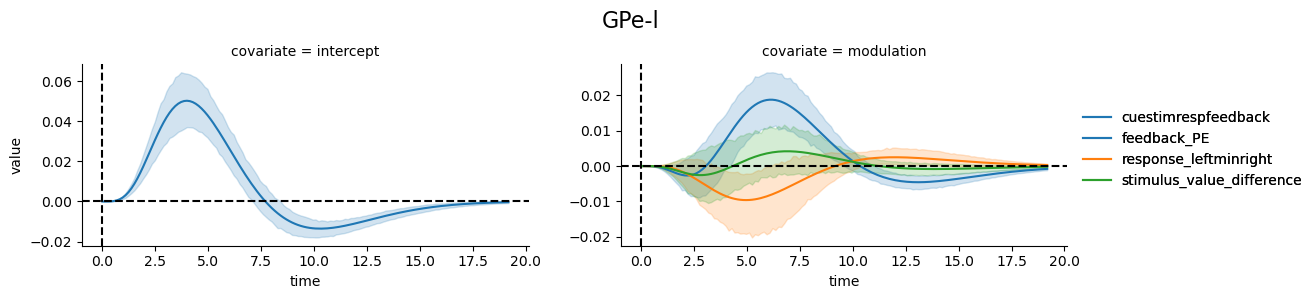

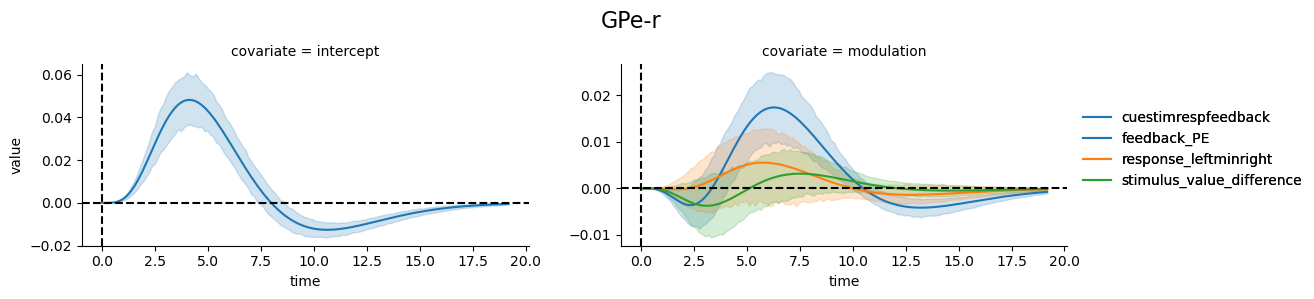

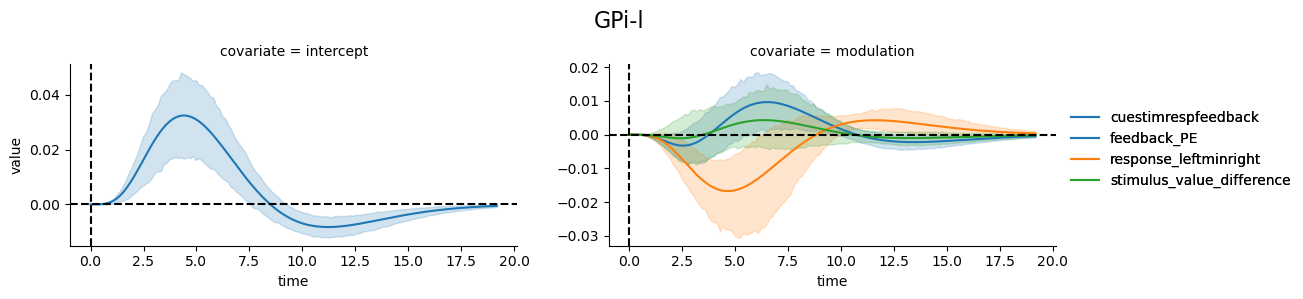

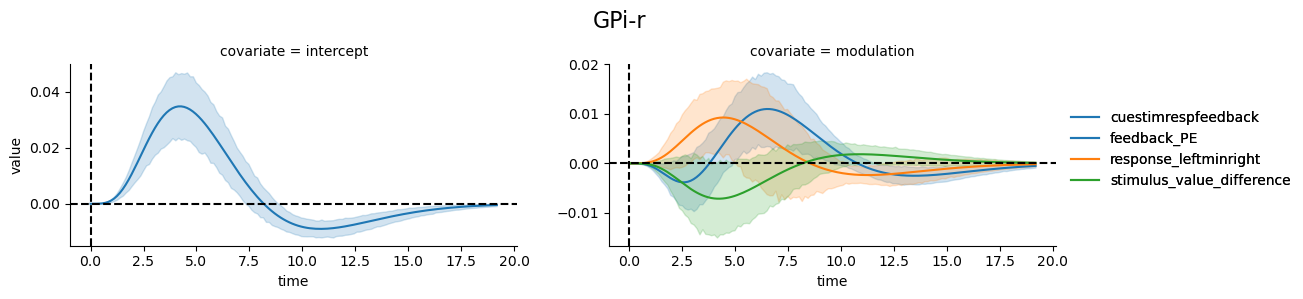

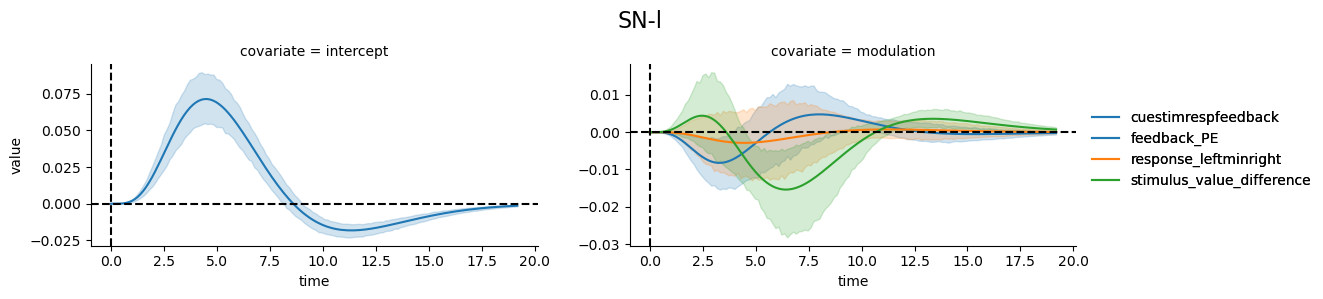

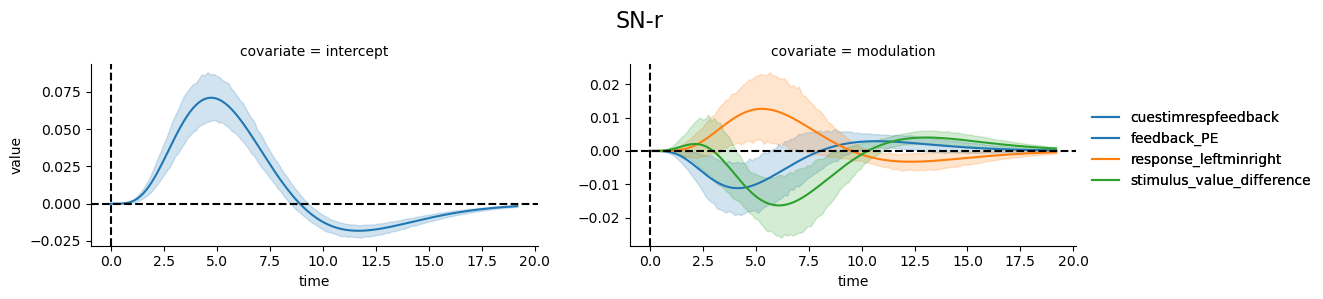

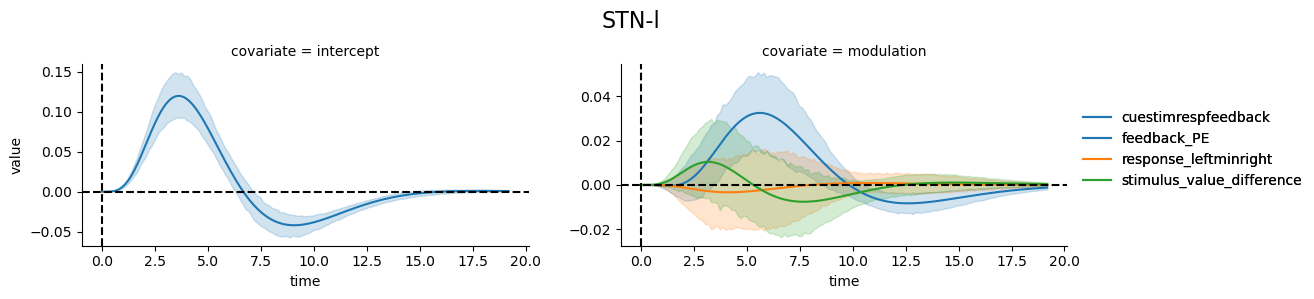

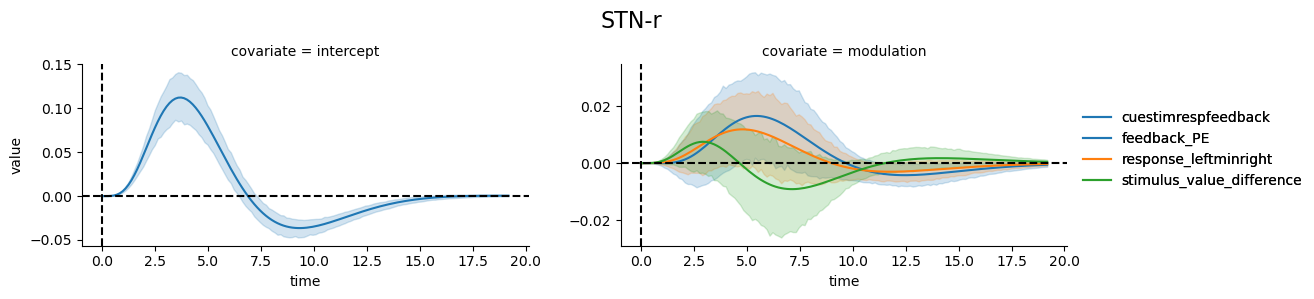

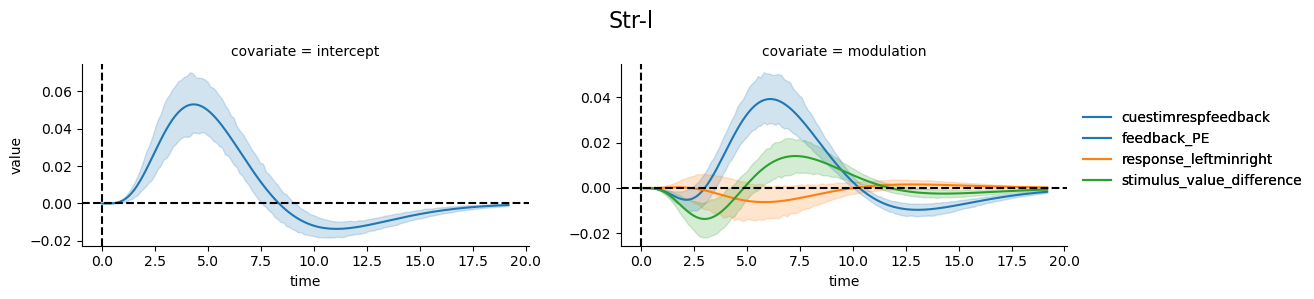

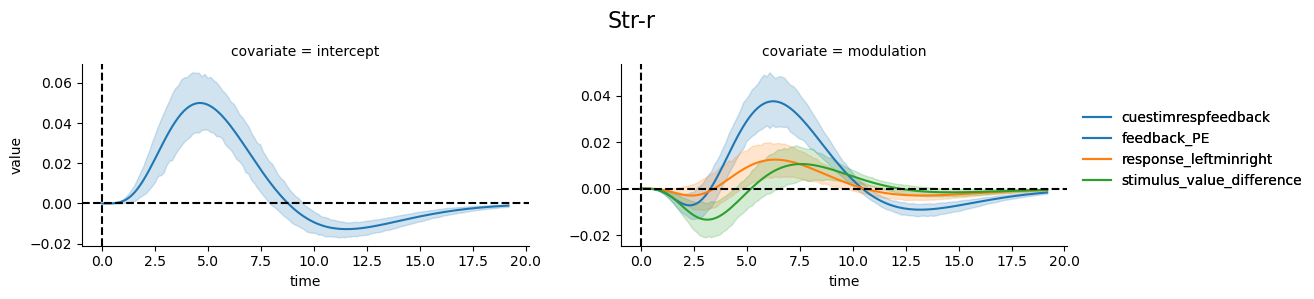

In [ ]:
glm1 = fit_glm(timeseries=timeseries, events=events, confounds=None, include_events=('cuestimrespfeedback', 'feedback_PE', 'stimulus_value_difference', 'response_leftminright'), include_rois=timeseries.columns.values)
glm1.plot_groupwise_timecourses()

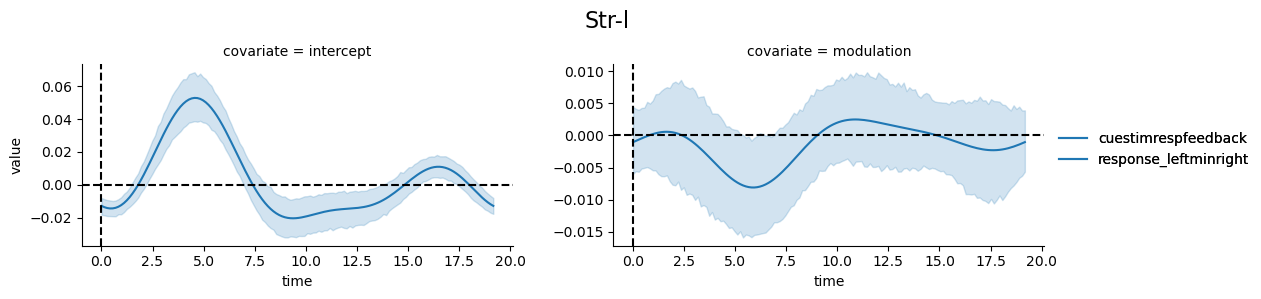

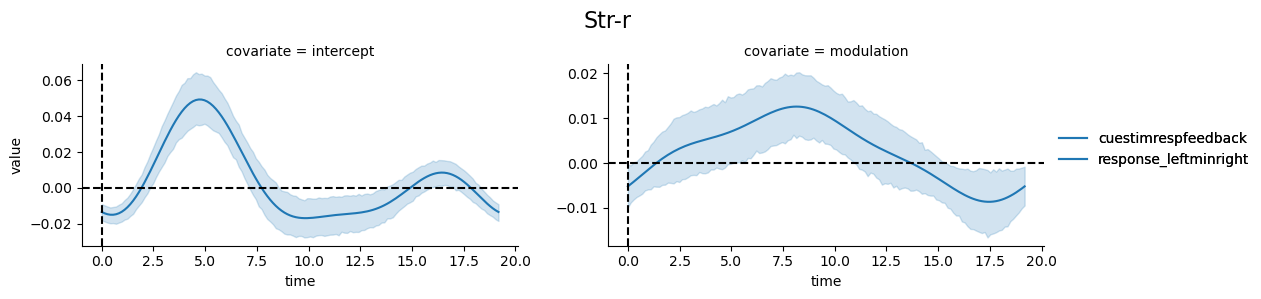

In [133]:
glm1 = fit_glm(timeseries=timeseries, events=events, confounds=None, include_events=('cuestimrespfeedback', 'response_leftminright'), include_rois=['Str-l', 'Str-r'], basis_set='fourier')
glm1.plot_groupwise_timecourses()

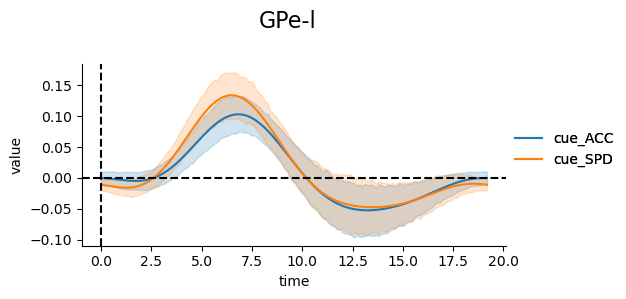

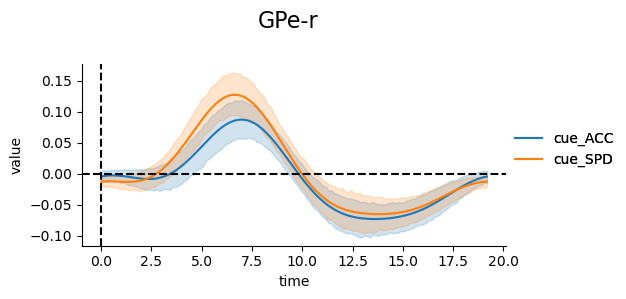

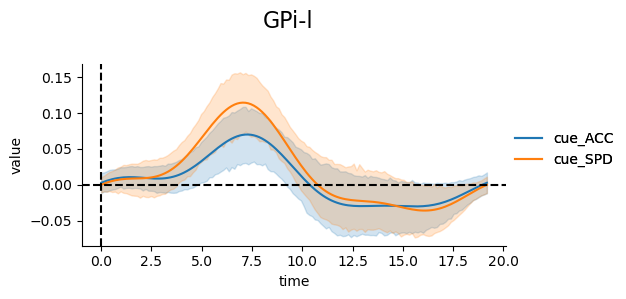

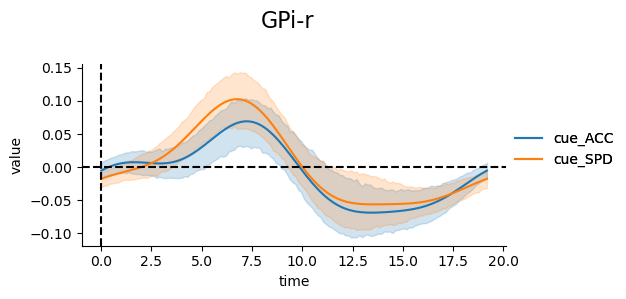

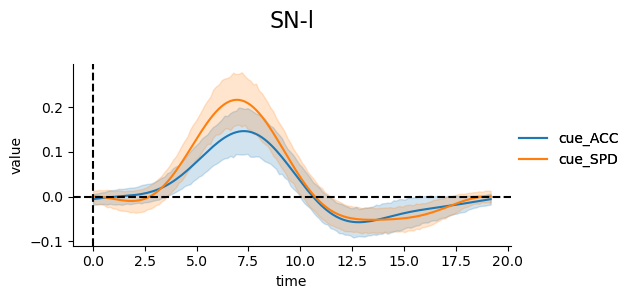

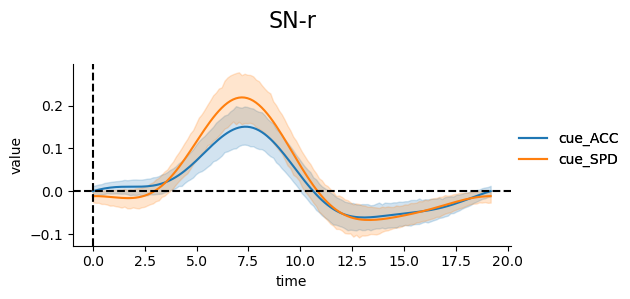

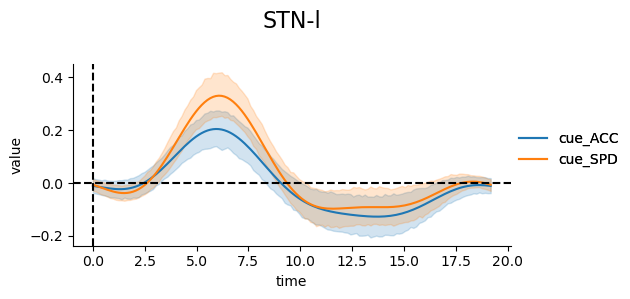

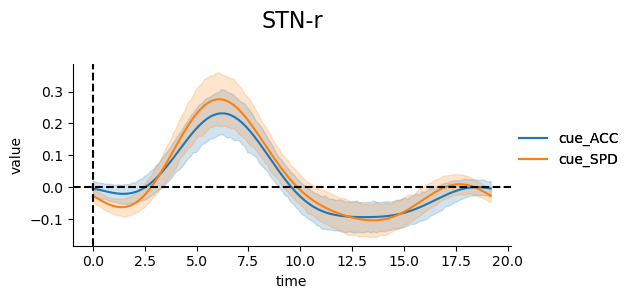

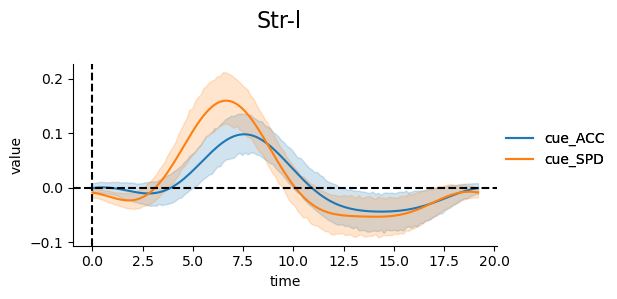

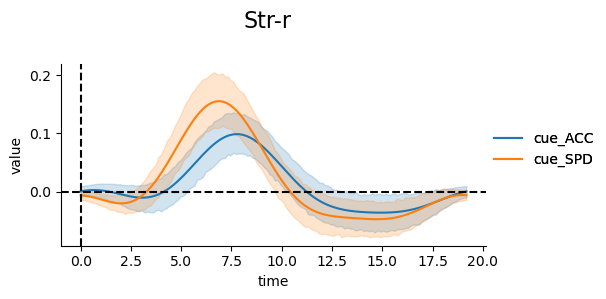

In [95]:
glm1 = fit_glm(timeseries=timeseries, events=events, confounds=None, include_events=('cue_SPD', 'cue_ACC'), include_rois=timeseries.columns.values)
glm1.plot_groupwise_timecourses()

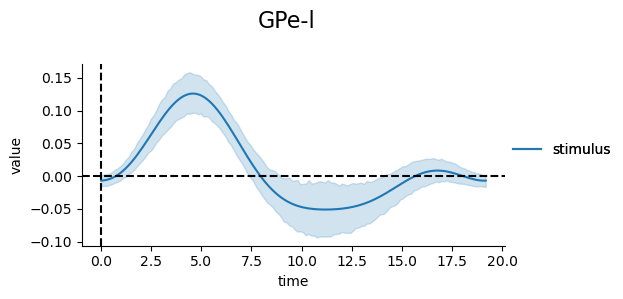

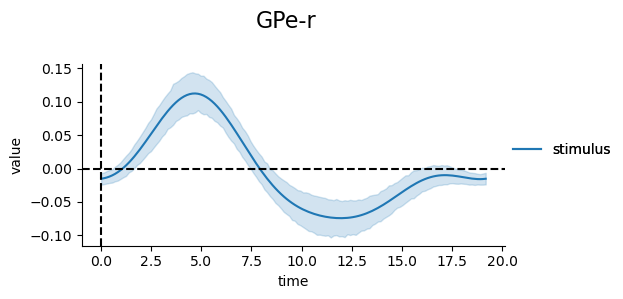

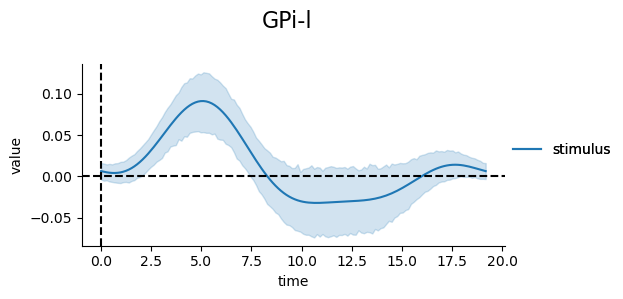

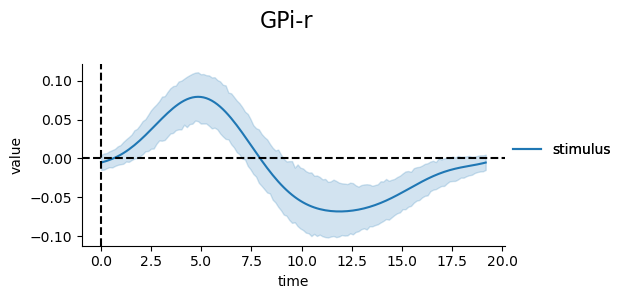

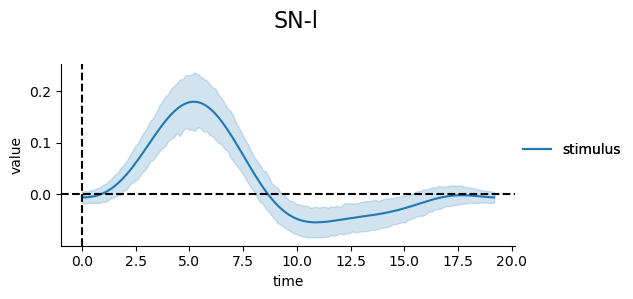

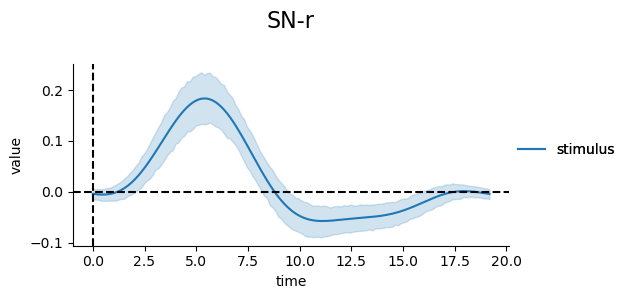

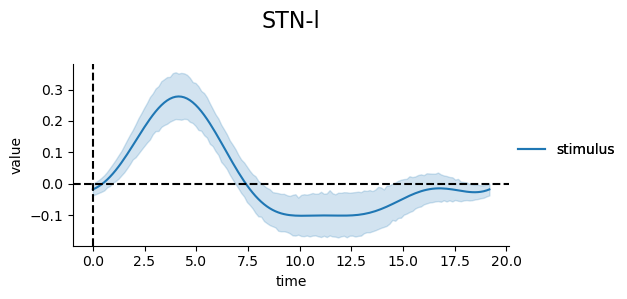

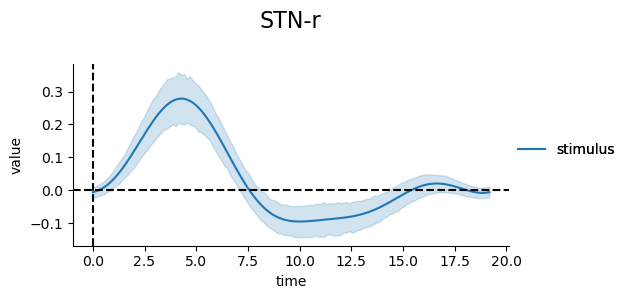

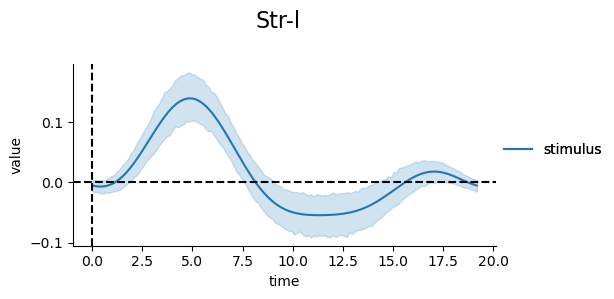

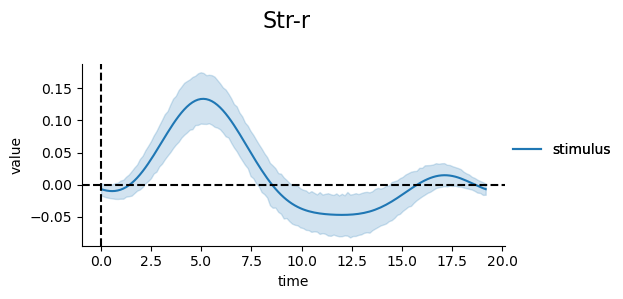

In [96]:
glm1 = fit_glm(timeseries=timeseries, events=events, confounds=None, include_events=('stimulus',), include_rois=timeseries.columns.values)
glm1.plot_groupwise_timecourses()

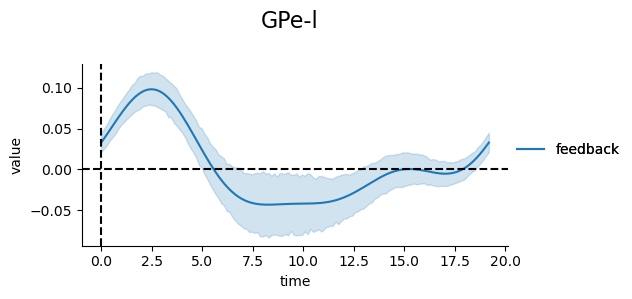

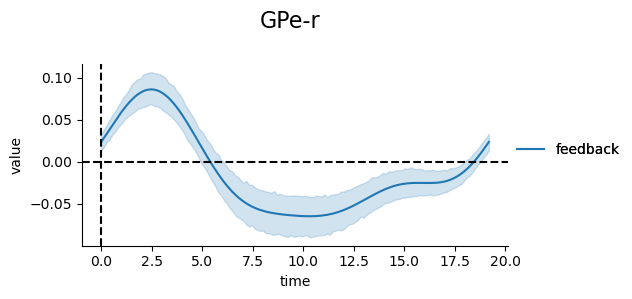

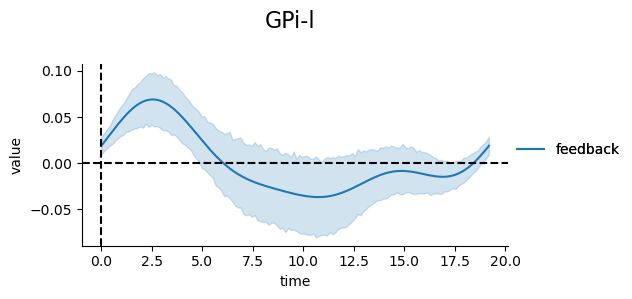

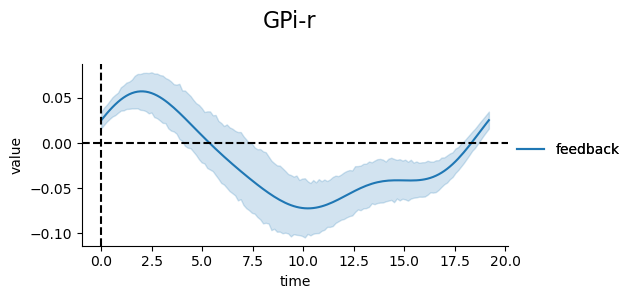

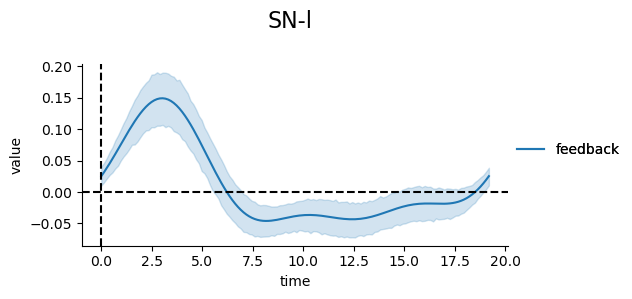

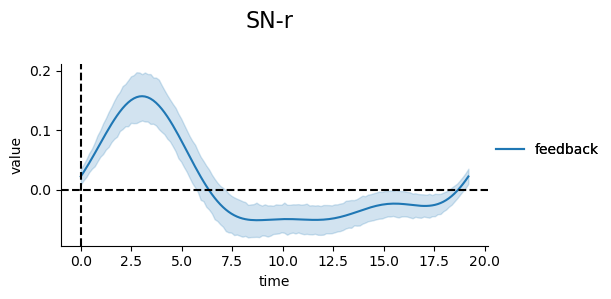

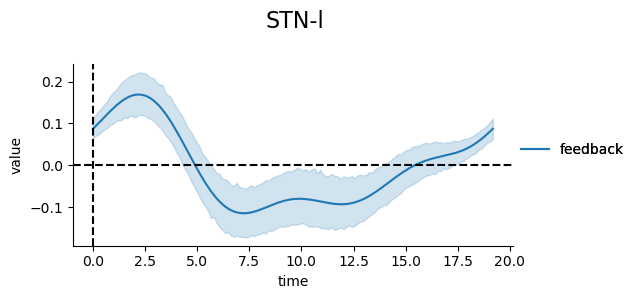

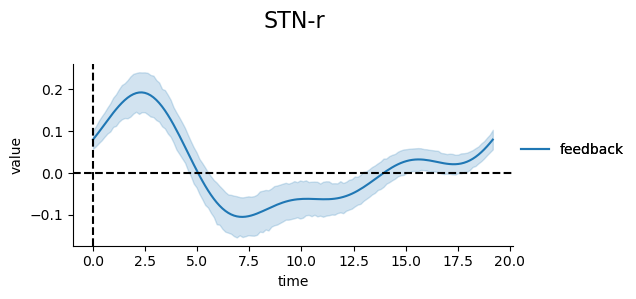

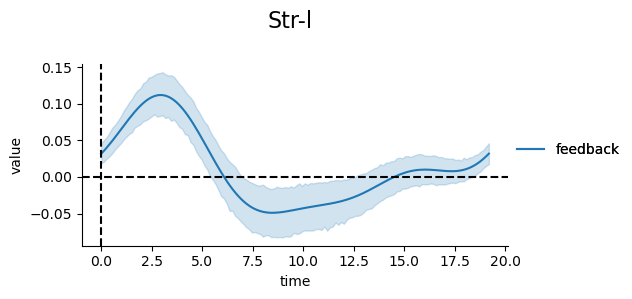

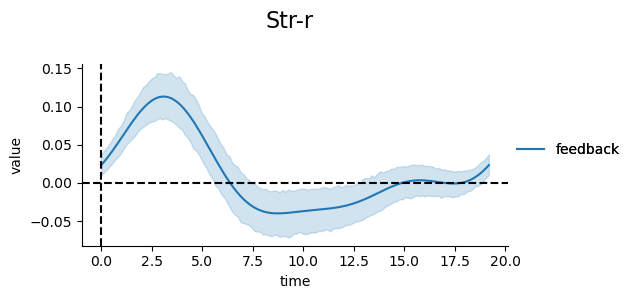

In [97]:
glm1 = fit_glm(timeseries=timeseries, events=events, confounds=None, include_events=('feedback',), include_rois=timeseries.columns.values)
glm1.plot_groupwise_timecourses()

In [28]:
def fit_glm(timeseries, events, confounds, include_events, include_rois, t_r=1.38, oversample_design_matrix=10, concatenate_runs=False, fit_type='ols'):
    events_1 = events.reset_index().set_index(['subject', 'run', 'event_type']).loc[(slice(None), slice(None), include_events),:]
    events_1 = events_1.reset_index().set_index(['subject', 'run', 'event_type'])
    events_1.onset -= t_r/2   # stc

    glm1 = GroupResponseFitter(timeseries.copy()[include_rois],
                               events_1, 
                               confounds=confounds.copy().reset_index() if confounds is not None else None,
                               input_sample_rate=1/t_r, 
                               oversample_design_matrix=oversample_design_matrix,
                               concatenate_runs=concatenate_runs)
    for event_type in include_events:
        if event_type in ['stimulus_value_difference', 'feedback_PE']:
            glm1.add_event(event_type, covariates='modulation', basis_set='canonical_hrf', interval=[0, 19.32])
        else:
            glm1.add_event(event_type, basis_set='canonical_hrf_with_time_derivative',  interval=[0, 19.32])

    glm1.fit(type=fit_type)
    return glm1

In [29]:
gm_nuclei = ['Amg', 'Cl', 'GPe', 'GPi', 'PAG', 'PPN', 'RN', 'SN', 'STN', 'Str', 'Tha', 'VTA']
include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]
include_events = ['cue_ACC', 'cue_SPD', 'feedback_PE'] #['response_left', 'response_right', 'cue_ACC', 'cue_SPD', 'stimulus_value_difference', 'feedback_PE']

glm1 = fit_glm(timeseries=df, events=events, confounds=None, include_events=include_events, include_rois=include_rois)

/home/stevenm/miniconda3/lib/python3.9/site-packages/nideconv/group_analysis.py:87: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.response_fitters = pd.Series(index=index)
/home/stevenm/miniconda3/lib/python3.9/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/stevenm/miniconda3/lib/python3.9/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/stevenm/miniconda3/lib/python3.9/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keywo

<AxesSubplot:xlabel='event type-covariate-regressor', ylabel='event type-covariate-regressor'>

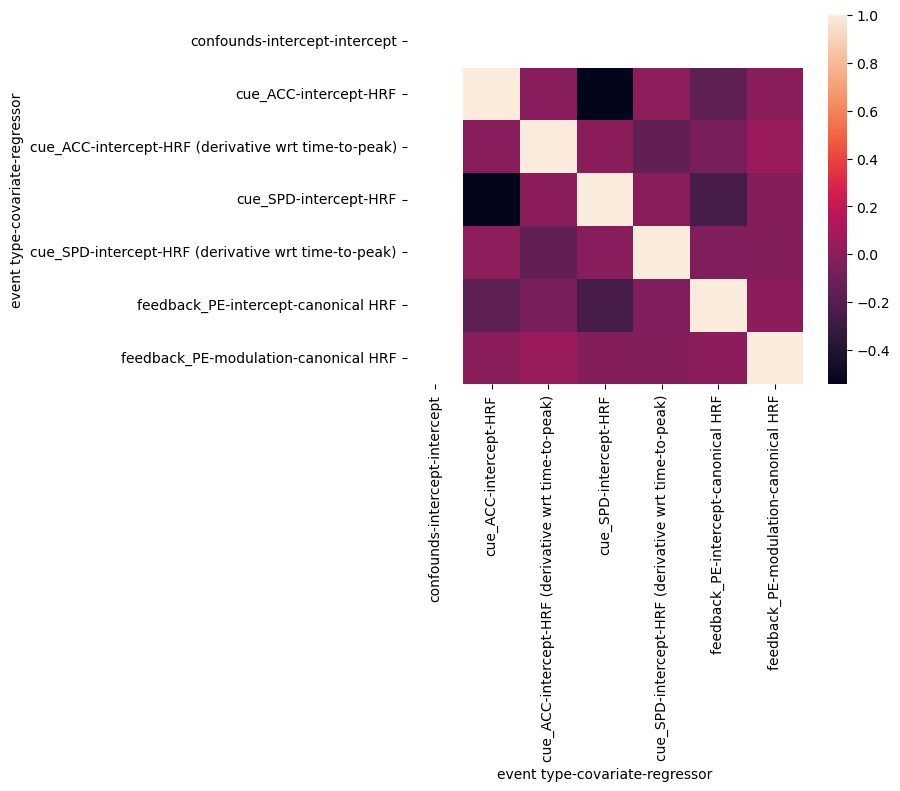

In [41]:
dm1 = glm1.response_fitters.iloc[2].X.corr()
sns.heatmap(dm1)

## Plot

#### Response left minus right

Text(0.5, 0, 'ROI')

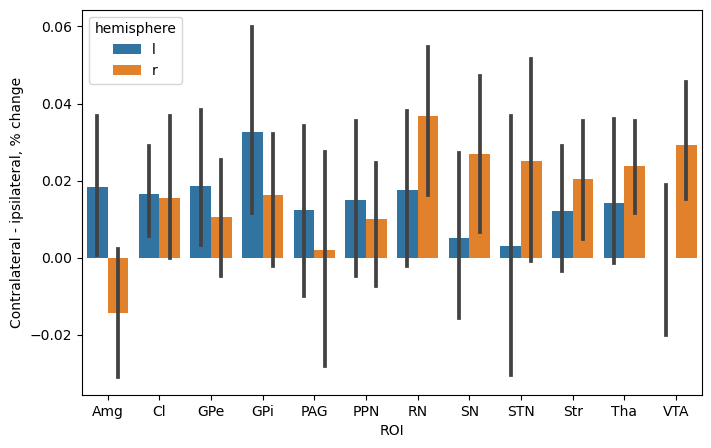

In [89]:
all_betas = glm1.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['response_left', 'response_right'], 'intercept', 'HRF')] # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True).groupby(level=0).diff()                   # Take difference right - left
contrast_betas = contrast_betas.xs('response_right',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_right-left', ignore_index=False)
contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])

## recode to contralateral vs ipsilateral
contrast_betas['beta_contra-ipsi'] = contrast_betas['beta_right-left'].copy()
contrast_betas.loc[contrast_betas.hemisphere == 'r', 'beta_contra-ipsi'] *= -1
contrast_betas_motor = contrast_betas.copy()

f, ax = plt.subplots(1,1,figsize=(8,5))
sns.barplot(x='ROI_nohemi', y='beta_contra-ipsi', hue='hemisphere', 
            data=contrast_betas, ax=ax)
ax.set_ylabel('Contralateral - ipsilateral, % change')
ax.set_xlabel('ROI')

#### Speed accuracy trade-off

ROI
Str-l    0.068371
Str-r    0.064732
Name: beta_spd-acc, dtype: float64


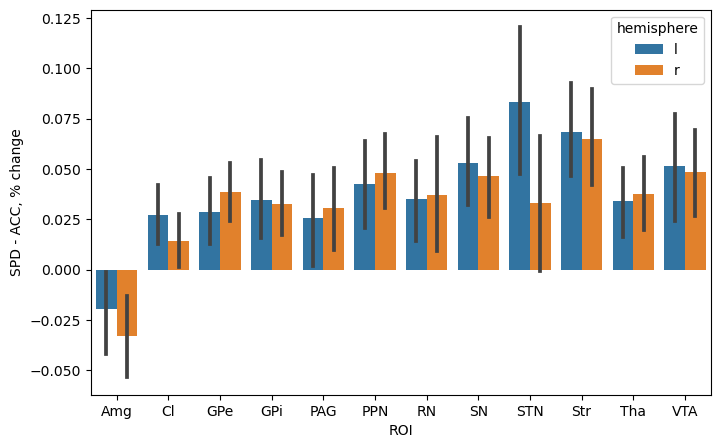

In [107]:
all_betas = glm1.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['cue_ACC', 'cue_SPD'], 'intercept', 'HRF')]              # Select only betas of interest
# subjectwise_betas[['STN-l', 'STN-r', 'Str-l', 'Str-r']].melt(ignore_index=False).reset_index().to_csv('./download-for-steven/betas_SAT.csv')

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True).groupby(level=0).diff()                   # Take difference SPD-ACC
contrast_betas = contrast_betas.xs('cue_SPD',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_spd-acc', ignore_index=False)
contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
contrast_betas_sat = contrast_betas.copy()


f, ax = plt.subplots(1,1,figsize=(8,5))
sns.barplot(x='ROI_nohemi', y='beta_spd-acc', hue='hemisphere', 
            data=contrast_betas, ax=ax)
ax.set_ylabel('SPD - ACC, % change')
ax.set_xlabel('ROI')

print(contrast_betas_sat.groupby('ROI')['beta_spd-acc'].mean()[['Str-l', 'Str-r']])

Text(0.5, 0, 'ROI')

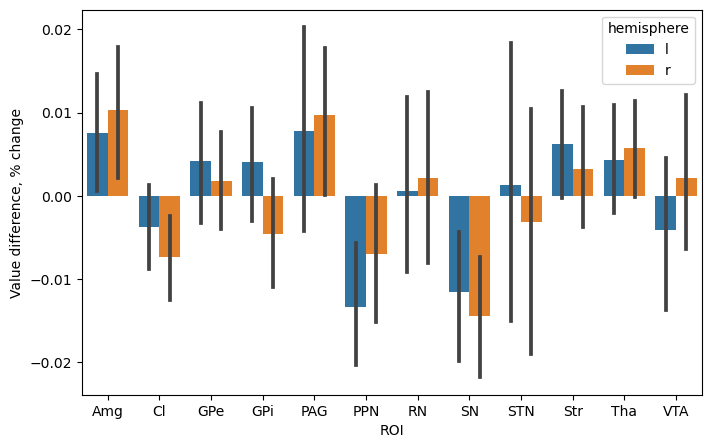

In [91]:
all_betas = glm1.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                      # Extract all betas to dataframe
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                       # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),'stimulus_value_difference', 'modulation', 'canonical HRF')] # Select only betas of interest

#contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True)
contrast_betas = subjectwise_betas.melt(var_name='ROI', value_name='beta_value_difference', ignore_index=False)
contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
contrast_betas_value = contrast_betas.copy()

f, ax = plt.subplots(1,1,figsize=(8,5))
sns.barplot(x='ROI_nohemi', y='beta_value_difference', hue='hemisphere', 
            data=contrast_betas, ax=ax)
ax.set_ylabel('Value difference, % change')
ax.set_xlabel('ROI')

Text(0.5, 0, 'ROI')

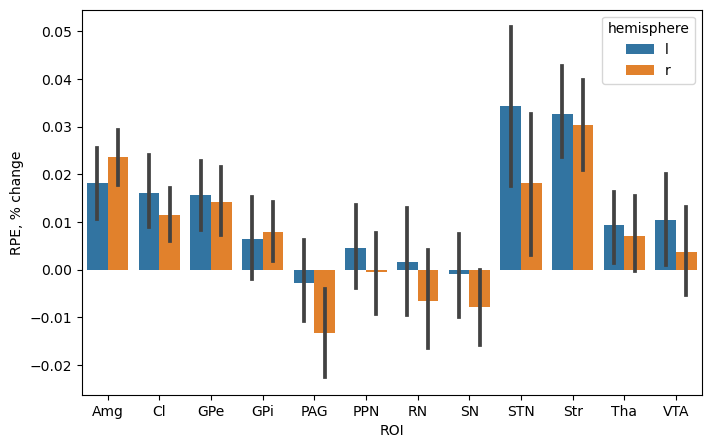

In [92]:
all_betas = glm1.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                      # Extract all betas to dataframe
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                       # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),'feedback_PE', 'modulation', 'canonical HRF')] # Select only betas of interest

#contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True)
contrast_betas = subjectwise_betas.melt(var_name='ROI', value_name='beta_PE', ignore_index=False)
contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
contrast_betas_rpe = contrast_betas.copy()


f, ax = plt.subplots(1,1,figsize=(8,5))
sns.barplot(x='ROI_nohemi', y='beta_PE', hue='hemisphere', 
            data=contrast_betas, ax=ax)
ax.set_ylabel('RPE, % change')
ax.set_xlabel('ROI')

### 4-plot?

In [93]:
tmp = contrast_betas_sat.groupby('ROI')['beta_spd-acc'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p'])
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df

,t,p,fdr_significant,p_corrected
Amg-l,-1.676894,0.102227,False,0.11152
Amg-r,-3.276143,0.002333,True,0.007
Cl-l,2.482239,0.017856,True,0.025209
Cl-r,1.377207,0.176952,False,0.176952
GPe-l,2.324004,0.025885,True,0.034513
GPe-r,4.197848,0.000169,True,0.000809
GPi-l,2.570218,0.014447,True,0.023115
GPi-r,2.980793,0.005128,True,0.010256
PAG-l,1.686026,0.100440,False,0.11152
PAG-r,2.287812,0.028127,True,0.035529


In [94]:
tmp = contrast_betas_motor.groupby('ROI')['beta_contra-ipsi'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p'])
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df

,t,p,fdr_significant,p_corrected
Amg-l,2.073596,0.045330,False,0.135991
Amg-r,-1.737702,0.090812,False,0.181625
Cl-l,2.894765,0.006410,True,0.038458
Cl-r,1.544790,0.131143,False,0.220138
GPe-l,1.992936,0.053891,False,0.143709
GPe-r,1.331854,0.191280,False,0.255039
GPi-l,2.546862,0.015288,False,0.056524
GPi-r,1.849973,0.072539,False,0.158268
PAG-l,1.035729,0.307236,False,0.368683
PAG-r,0.131154,0.896384,False,0.935357


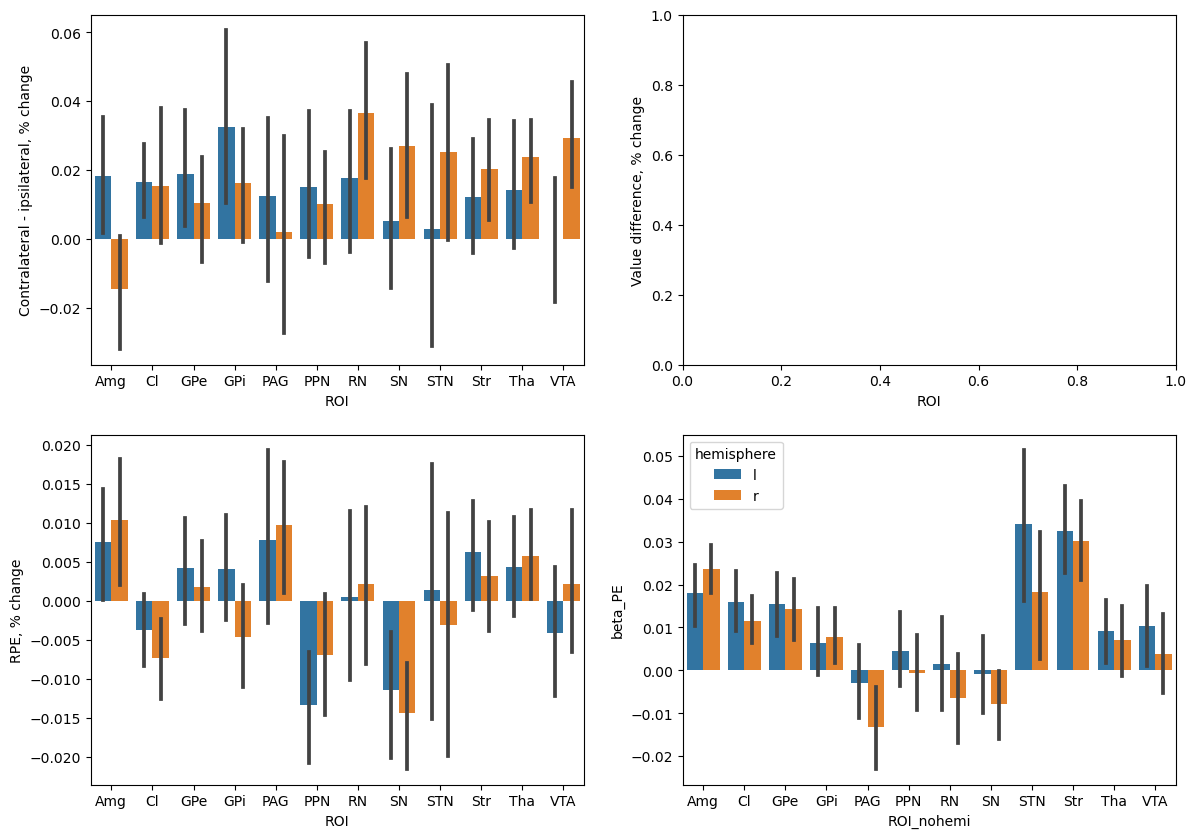

In [96]:
f, axes = plt.subplots(2,2, figsize=(14,10))
ax = axes.ravel()

## 1
sns.barplot(x='ROI_nohemi', y='beta_contra-ipsi', hue='hemisphere', 
            data=contrast_betas_motor, ax=ax[0])
ax[0].set_ylabel('Contralateral - ipsilateral, % change')
ax[0].set_xlabel('ROI')
ax[0].legend_.remove()

## 2
sns.barplot(x='ROI_nohemi', y='beta_value_difference', hue='hemisphere', 
            data=contrast_betas_value, ax=ax[2])
ax[1].set_ylabel('Value difference, % change')
ax[1].set_xlabel('ROI')
#ax[1].legend_.remove()
## 3

sns.barplot(x='ROI_nohemi', y='beta_PE', hue='hemisphere', 
            data=contrast_betas_rpe, ax=ax[3])
ax[2].set_ylabel('RPE, % change')
ax[2].set_xlabel('ROI')
ax[2].legend_.remove()

# f.savefig('download-for-steven/GLM_ROI_unfiltered.pdf', bbox_inches='tight')

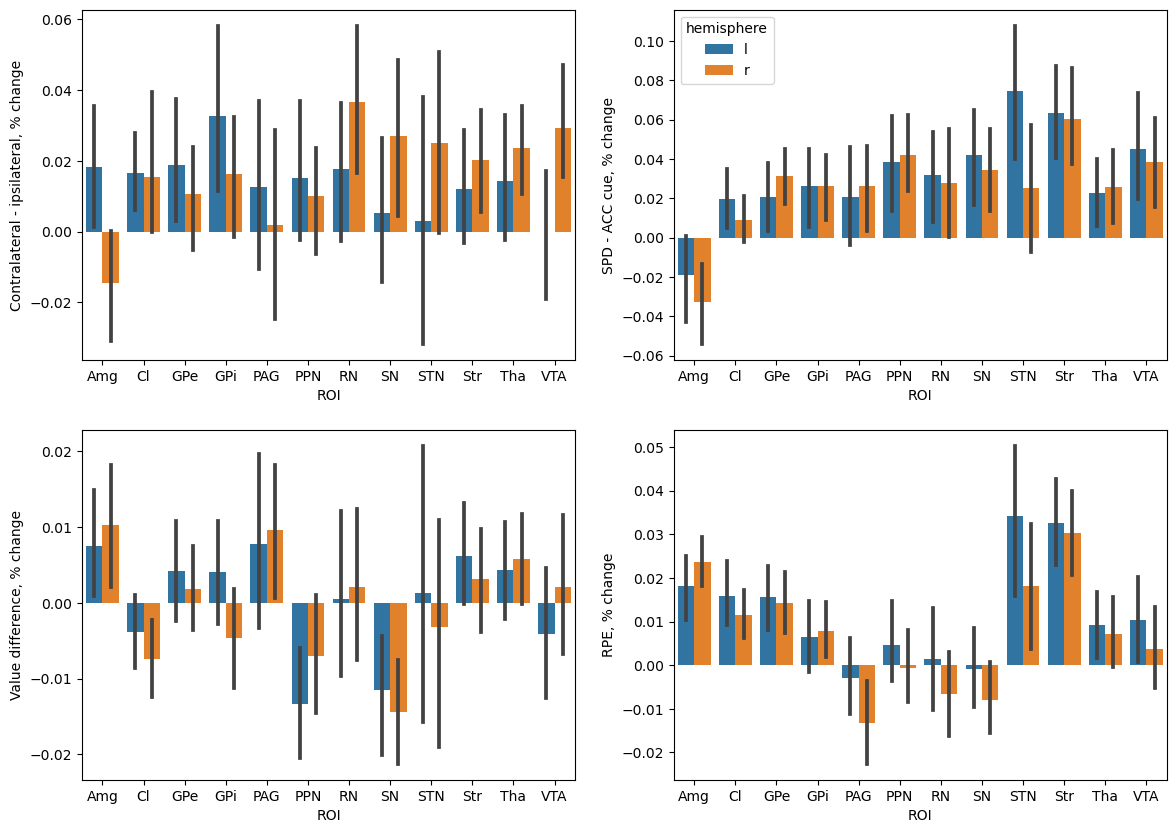

In [97]:
f, axes = plt.subplots(2,2, figsize=(14,10))
ax = axes.ravel()

## 1
sns.barplot(x='ROI_nohemi', y='beta_contra-ipsi', hue='hemisphere', 
            data=contrast_betas_motor, ax=ax[0])
ax[0].set_ylabel('Contralateral - ipsilateral, % change')
ax[0].set_xlabel('ROI')
ax[0].legend_.remove()

## 2
sns.barplot(x='ROI_nohemi', y='beta_spd-acc', hue='hemisphere', 
            data=contrast_betas_sat, ax=ax[1])
ax[1].set_ylabel('SPD - ACC cue, % change')
ax[1].set_xlabel('ROI')

## 3
sns.barplot(x='ROI_nohemi', y='beta_value_difference', hue='hemisphere', 
            data=contrast_betas_value, ax=ax[2])
ax[2].set_ylabel('Value difference, % change')
ax[2].set_xlabel('ROI')
ax[2].legend_.remove()

## 4
sns.barplot(x='ROI_nohemi', y='beta_PE', hue='hemisphere', 
            data=contrast_betas_rpe, ax=ax[3])
ax[3].set_ylabel('RPE, % change')
ax[3].set_xlabel('ROI')
ax[3].legend_.remove()

#f.savefig('download-for-steven/GLM_ROI_filtered.pdf', bbox_inches='tight')

In [189]:
contrast_betas_motor_unilateral = contrast_betas_motor.reset_index().groupby(['subject', 'ROI_nohemi'])['beta_contra-ipsi'].mean().reset_index()
tmp = contrast_betas_motor_unilateral.groupby('ROI_nohemi')['beta_contra-ipsi'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p'])
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i', alpha=0.05/4), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df


#stat_df.columns = ['t', 'p']
# stat_df['p_corrected'] = statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i')[1]
# stat_df['significant'] = statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i')[0]
# stat_df

,t,p,fdr_significant,p_corrected
Amg,-0.366360,7.165075e-01,False,0.716508
Cl,4.172325,2.153001e-04,True,0.000517
GPe,3.555788,1.197198e-03,True,0.001796
GPi,6.629670,1.776650e-07,True,0.000001
PAG,2.196896,3.538646e-02,False,0.042464
PPN,2.691246,1.122366e-02,False,0.014965
RN,5.465353,5.128706e-06,True,0.000015
SN,3.789065,6.309964e-04,True,0.001082
STN,1.229209,2.279557e-01,False,0.248679
Str,9.930110,2.690775e-11,True,0.0


In [169]:
stat_df

,t,p
Amg,-0.366360,7.165075e-01
Cl,4.172325,2.153001e-04
GPe,3.555788,1.197198e-03
GPi,6.629670,1.776650e-07
PAG,2.196896,3.538646e-02
PPN,2.691246,1.122366e-02
RN,5.465353,5.128706e-06
SN,3.789065,6.309964e-04
STN,1.229209,2.279557e-01
Str,9.930110,2.690775e-11


In [113]:
contrast_betas_sat_unilateral = contrast_betas_sat.reset_index().groupby(['subject', 'ROI_nohemi'])['beta_spd-acc'].mean().reset_index()
tmp = contrast_betas_sat_unilateral.groupby('ROI_nohemi')['beta_spd-acc'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))    #, axis=0)
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values))).T
stat_df.columns = ['t', 'p']
stat_df['p_corrected'] = statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i')[1]
stat_df['significant'] = statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i')[0]
stat_df

,t,p,p_corrected,significant
Amg,-3.266816,2.597555e-03,3.463407e-03,True
Cl,3.076606,4.267609e-03,5.121130e-03,True
GPe,4.029575,3.222820e-04,5.524834e-04,True
GPi,2.788651,8.837318e-03,9.640710e-03,True
PAG,1.950869,5.987549e-02,5.987549e-02,False
PPN,4.247590,1.738433e-04,5.215300e-04,True
RN,3.443468,1.622120e-03,2.433180e-03,True
SN,4.480474,8.929919e-05,4.312856e-04,True
STN,4.084584,2.759851e-04,5.524834e-04,True
Str,7.381533,2.139272e-08,2.567126e-07,True


In [114]:
contrast_betas_value_unilateral = contrast_betas_value.reset_index().groupby(['subject', 'ROI_nohemi'])['beta_value_difference'].mean().reset_index()
tmp = contrast_betas_value_unilateral.groupby('ROI_nohemi')['beta_value_difference'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))    #, axis=0)
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values))).T
stat_df.columns = ['t', 'p']
stat_df['p_corrected'] = statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i')[1]
stat_df['significant'] = statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i')[0]
stat_df

,t,p,p_corrected,significant
Amg,0.835995,0.409357,0.641571,False
Cl,-0.803325,0.427714,0.641571,False
GPe,0.261801,0.795153,0.867440,False
GPi,0.121103,0.904367,0.904367,False
PAG,-1.023854,0.313582,0.641571,False
PPN,-2.901115,0.006675,0.040048,True
RN,1.224339,0.229762,0.641571,False
SN,-4.170316,0.000217,0.002598,True
STN,-0.976824,0.335984,0.641571,False
Str,0.679225,0.501879,0.669172,False


In [115]:
contrast_betas_rpe_unilateral = contrast_betas_rpe.reset_index().groupby(['subject', 'ROI_nohemi'])['beta_PE'].mean().reset_index()
tmp = contrast_betas_rpe_unilateral.groupby('ROI_nohemi')['beta_PE'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))    #, axis=0)
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values))).T
stat_df.columns = ['t', 'p']
stat_df['p_corrected'] = statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i')[1]
stat_df['significant'] = statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i')[0]
stat_df

,t,p,p_corrected,significant
Amg,6.101414,8.095671e-07,0.000010,True
Cl,1.988385,5.537916e-02,0.119586,False
GPe,1.640868,1.106190e-01,0.169350,False
GPi,0.521707,6.054666e-01,0.660509,False
PAG,-1.432312,1.617514e-01,0.215668,False
PPN,-1.192587,2.417995e-01,0.290159,False
RN,-1.951536,5.979280e-02,0.119586,False
SN,-2.106211,4.311986e-02,0.119586,False
STN,2.353658,2.489622e-02,0.099585,False
Str,3.563947,1.170925e-03,0.007026,True


In [ ]:
scipy.stats.ttest_1samp(a, popmean, axis=0)


Text(0.5, 0, 'ROI')

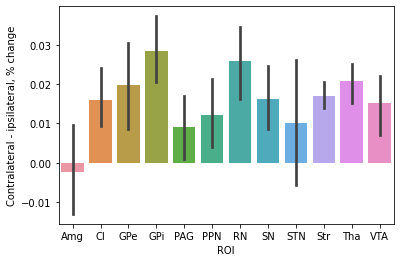

In [75]:
g = sns.barplot(x='ROI_nohemi', y='beta_contra-ipsi', 
                data=contrast_betas_motor_unilateral)
g.set_ylabel('Contralateral - ipsilateral, % change')
g.set_xlabel('ROI')

TypeError: fdrcorrection() missing 1 required positional argument: 'pvals'

In [92]:
contrast_betas_motor_unilateral = contrast_betas_motor.reset_index().groupby(['subject', 'ROI_nohemi'])['beta_contra-ipsi'].mean().reset_index()
tmp = contrast_betas_motor_unilateral.groupby('ROI_nohemi')['beta_contra-ipsi'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))    #, axis=0)
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values))).T
stat_df.columns = ['t', 'p']
statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i')

(array([False,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True]),
 array([7.16507508e-01, 5.16720135e-04, 1.79579680e-03, 7.10660068e-07,
        4.24637574e-02, 1.49648814e-02, 1.53861194e-05, 1.08170817e-03,
        2.48678931e-01, 3.22892948e-10, 2.49392508e-08, 1.00851900e-03]))

Text(0.5, 0, 'ROI')

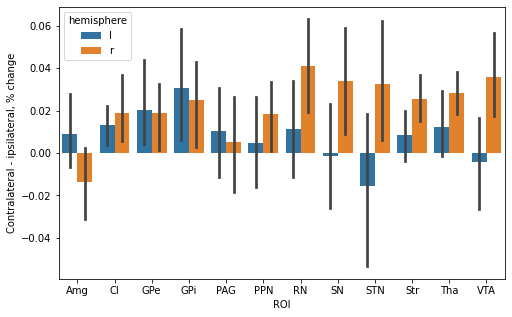

In [24]:
all_betas = glm1.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['response_left', 'response_right'], 'intercept', 'HRF')] # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True).groupby(level=0).diff()                   # Take difference right - left
contrast_betas = contrast_betas.xs('response_right',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_right-left')
contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])

## recode to contralateral vs ipsilateral
contrast_betas['beta_contra-ipsi'] = contrast_betas['beta_right-left'].copy()
contrast_betas.loc[contrast_betas.hemisphere == 'r', 'beta_contra-ipsi'] *= -1

f, ax = plt.subplots(1,1,figsize=(8,5))
sns.barplot(x='ROI_nohemi', y='beta_contra-ipsi', hue='hemisphere', 
            data=contrast_betas, ax=ax)
ax.set_ylabel('Contralateral - ipsilateral, % change')
ax.set_xlabel('ROI')

Text(0.5, 0, 'ROI')

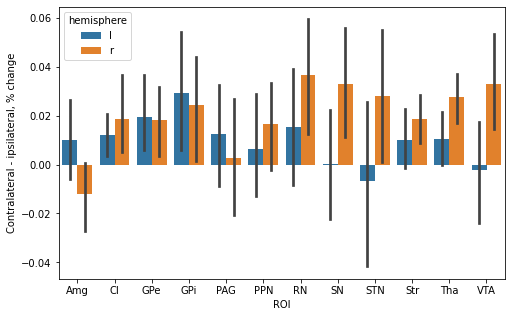

In [26]:
all_betas = glm1_ar1.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['response_left', 'response_right'], 'intercept', 'HRF')] # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True).groupby(level=0).diff()                   # Take difference right - left
contrast_betas = contrast_betas.xs('response_right',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_right-left')
contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])

## recode to contralateral vs ipsilateral
contrast_betas['beta_contra-ipsi'] = contrast_betas['beta_right-left'].copy()
contrast_betas.loc[contrast_betas.hemisphere == 'r', 'beta_contra-ipsi'] *= -1

f, ax = plt.subplots(1,1,figsize=(8,5))
sns.barplot(x='ROI_nohemi', y='beta_contra-ipsi', hue='hemisphere', 
            data=contrast_betas, ax=ax)
ax.set_ylabel('Contralateral - ipsilateral, % change')
ax.set_xlabel('ROI')

In [ ]:
all_betas = glm1.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['response_left', 'response_right'], 'intercept', 'HRF')] # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True).groupby(level=0).diff()                   # Take difference right - left
contrast_betas = contrast_betas.xs('response_right',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_right-left')
contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])

## recode to contralateral vs ipsilateral
contrast_betas['beta_contra-ipsi'] = contrast_betas['beta_right-left'].copy()
contrast_betas.loc[contrast_betas.hemisphere == 'r', 'beta_contra-ipsi'] *= -1

f, ax = plt.subplots(1,1,figsize=(8,5))
sns.barplot(x='ROI_nohemi', y='beta_contra-ipsi', hue='hemisphere', 
            data=contrast_betas, ax=ax)
ax.set_ylabel('Contralateral - ipsilateral, % change')
ax.set_xlabel('ROI')

### GLM 2: SPD-ACC

In [31]:
gm_nuclei = ['Amg', 'Cl', 'GPe', 'GPi', 'PAG', 'PPN', 'RN', 'SN', 'STN', 'Str', 'Tha', 'VTA']
include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]
include_events = ['cue_SPD', 'cue_ACC']

glm2 = fit_glm(timeseries=df, events=events, confounds=confounds, include_events=include_events, include_rois=include_rois)

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


In [ ]:
tc = glm2.get_subjectwise_timecourses()
tc = tc.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')
tc['hemisphere'] = tc['roi'].str.split('-').apply(lambda x: x[-1])
tc['roi_nohemi'] = tc['roi'].str.split('-').apply(lambda x: x[0])
tc.loc[~tc.hemisphere.isin(['l', 'r']), 'hemisphere'] = 'lr'

g = sns.FacetGrid(col='roi', data=tc.loc[(tc['event type'].isin(include_events)) & (tc['covariate'] == 'intercept')], col_wrap=4, hue='event type')

for ax in g.axes.ravel():
    ax.axhline(0, color='lightgray', linestyle='--')
g.map(sns.lineplot, 'time', 'signal', n_boot=100)

Text(0.5, 0, 'ROI')

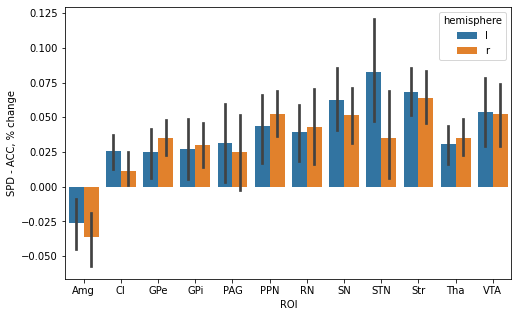

In [32]:
all_betas = glm2.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['cue_ACC', 'cue_SPD'], 'intercept', 'HRF')]              # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True).groupby(level=0).diff()                   # Take difference SPD-ACC
contrast_betas = contrast_betas.xs('cue_SPD',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_spd-acc')
contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])

f, ax = plt.subplots(1,1,figsize=(8,5))
sns.barplot(x='ROI_nohemi', y='beta_spd-acc', hue='hemisphere', 
            data=contrast_betas, ax=ax)
ax.set_ylabel('SPD - ACC, % change')
ax.set_xlabel('ROI')

## GLM 3: value differences

In [30]:
gm_nuclei = ['Amg', 'Cl', 'GPe', 'GPi', 'PAG', 'PPN', 'RN', 'SN', 'STN', 'Str', 'Tha', 'VTA']
include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]
include_events = ['stimulus_value_difference']

glm3 = fit_glm(timeseries=df, events=events, confounds=confounds, include_events=include_events, include_rois=include_rois)
tc = glm3.get_subjectwise_timecourses()
tc = tc.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  self.X = pd.concat((regressor.X, self.X), 1)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  self.X = pd.concat((self.X, regressor.X), 1)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nideconv/group_analysis.py:176: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  (intercept_matrix, covariate_matrix), 1)


In [ ]:
g = sns.FacetGrid(col='roi', data=tc.loc[(tc['event type'].isin(include_events)) & (tc['covariate'] == 'modulation')], col_wrap=4)

for ax in g.axes.ravel():
    ax.axhline(0, color='lightgray', linestyle='--')
g.map(sns.lineplot, 'time', 'signal', n_boot=100)

In [ ]:
all_betas = glm3.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                      # Extract all betas to dataframe
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                       # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),'stimulus_value_difference', 'modulation', 'canonical HRF')] # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_value_difference')
contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])


f, ax = plt.subplots(1,1,figsize=(8,5))
sns.barplot(x='ROI_nohemi', y='beta_value_difference', hue='hemisphere', 
            data=contrast_betas, ax=ax)
ax.set_ylabel('Value difference, % change')
ax.set_xlabel('ROI')

## GLM 4: RPE

In [116]:
gm_nuclei = ['Amg', 'Cl', 'GPe', 'GPi', 'PAG', 'PPN', 'RN', 'SN', 'STN', 'Str', 'Tha', 'VTA']
include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]
include_events = ['feedback_PE']

glm4 = fit_glm(timeseries=df, events=events, confounds=confounds, include_events=include_events, include_rois=include_rois)

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  self.X = pd.concat((regressor.X, self.X), 1)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  self.X = pd.concat((self.X, regressor.X), 1)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nideconv/group_analysis.py:176: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  (intercept_matrix, covariate_matrix), 1)


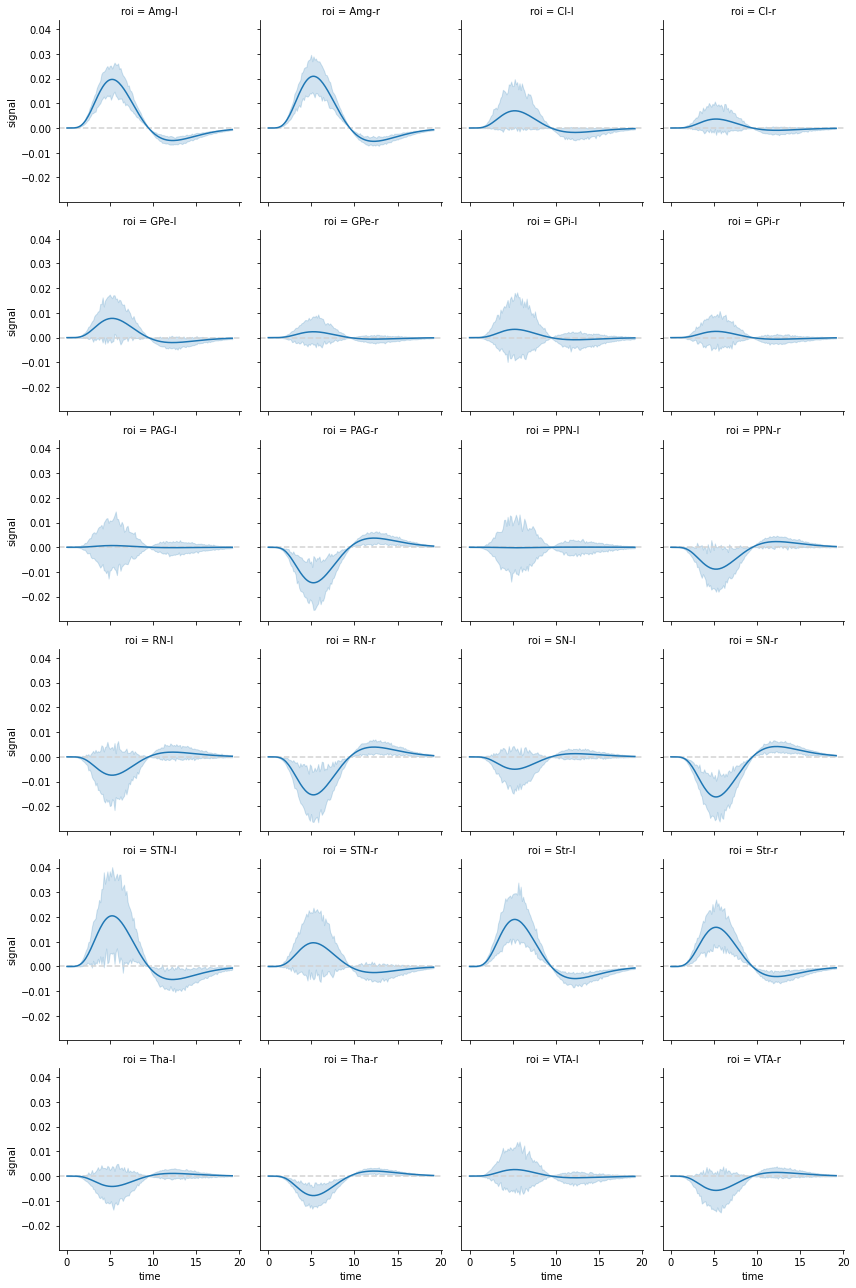

In [117]:
tc = glm4.get_subjectwise_timecourses()
tc = tc.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')
g = sns.FacetGrid(col='roi', data=tc.loc[(tc['event type'].isin(include_events)) & (tc['covariate'] == 'modulation')], col_wrap=4)

for ax in g.axes.ravel():
    ax.axhline(0, color='lightgray', linestyle='--')
g.map(sns.lineplot, 'time', 'signal', n_boot=100)

Text(0.5, 0, 'ROI')

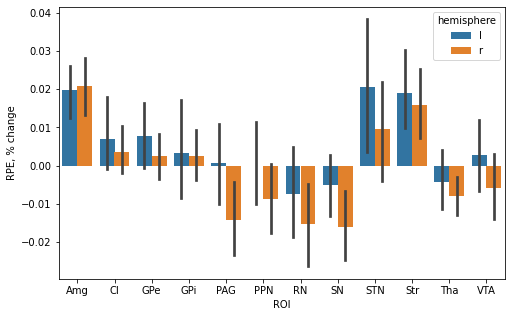

In [118]:
all_betas = glm4.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                      # Extract all betas to dataframe
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                       # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),'feedback_PE', 'modulation', 'canonical HRF')] # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_PE')
contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])


f, ax = plt.subplots(1,1,figsize=(8,5))
sns.barplot(x='ROI_nohemi', y='beta_PE', hue='hemisphere', 
            data=contrast_betas, ax=ax)
ax.set_ylabel('RPE, % change')
ax.set_xlabel('ROI')

In [ ]:
# events_1 = events.reset_index().set_index(['subject', 'run', 'event_type']).loc[(slice(None), slice(None), include_events),:]  # events_final.loc[events_final['event_type'].isin(['cue_ACC', 'cue_SPD', 'stimulus', 'feedback', 'response_left', 'response_right'])]
# events_1 = events_1.reset_index().set_index(['subject', 'run', 'event_type'])
# events_1.onset -= 1.38/2   # stc


# glm1 = GroupResponseFitter(df.copy()[include_rois],
#                            events_1, 
#                            confounds=confounds.copy().reset_index(),
#                            input_sample_rate=1/1.38, 
#                            oversample_design_matrix=10,
#                            concatenate_runs=False)
# for event_type in include_events:
#     if event_type in ['stimulus_value_difference', 'feedback_PE']:
#         glm1.add_event(event_type, covariates='modulation', basis_set='canonical_hrf', interval=[0, 18])
#     else:
#         glm1.add_event(event_type, basis_set='canonical_hrf_with_time_derivative',  interval=[0, 18])
#     # glm1.add_event(event_type, basis_set='canonical_hrf_with_time_derivative', interval=[0, 18])
#     # glm1.add_event(event_type, basis_set='fourier', n_regressors=8, interval=[0, 18])

# glm1.fit()
# # glm1.plot_groupwise_timecourses()

In [ ]:
# # plot
# tc = glm1.get_subjectwise_timecourses()
# tc = tc.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')
# tc['hemisphere'] = tc['roi'].str.split('-').apply(lambda x: x[-1])
# tc['roi_nohemi'] = tc['roi'].str.split('-').apply(lambda x: x[0])
# tc.loc[~tc.hemisphere.isin(['l', 'r']), 'hemisphere'] = 'lr'

# sns.set_context('talk')

# plot_rois = gm_nuclei
# f, ax = plt.subplots(len(plot_rois),2, figsize=(10,4*len(plot_rois)), sharey='row')

# for i, roi in enumerate(plot_rois):
#     for ii, hemi in enumerate(['l', 'r']):
#         this_roi = roi + '-' + hemi
#         ax[i,ii].axhline(0, color='k')
#         for contrast in include_events:
#             tc_subs = tc.loc[(tc['event type'] == contrast) & (tc['roi']==this_roi)]
#             # group_mean = tc_subs.loc[tc_subs['roi'] == this_roi].groupby(['time'])['signal'].mean()
#             sns.lineplot(x='time', y='signal', data=tc_subs, ax=ax[i,ii], label=contrast,n_boot=100, legend=False)
#             # ax[i,ii].plot(group_mean, label=contrast)
#             ax[i,ii].set_title(this_roi)

# ax[0,1].legend()
# plt.tight_layout()
# sns.despine()

### Annie's <s>ridiculous</s>  super awesome suggestion

man, she is smart. 

you're welcome. *act*



In [120]:
events_tmp = events.copy()

In [126]:
events['condition'] = np.nan
events.loc[events.event_type == 'cue_ACC', 'condition'] = 'ACC'
events.loc[events.event_type == 'cue_SPD', 'condition'] = 'SPD'
events['condition'] = events['condition'].ffill()
events.loc[(events.event_type == 'feedback_PE') & (events.condition == 'ACC'), 'event_type'] = 'feedback_PE_ACC'
events.loc[(events.event_type == 'feedback_PE') & (events.condition == 'SPD'), 'event_type'] = 'feedback_PE_SPD'
events.loc[(events.event_type == 'feedback_PE_SPD'), 'modulation'].groupby(level=[0,1]).apply(lambda x: (x-x.mean())/x.std())
events.loc[(events.event_type == 'feedback_PE_ACC'), 'modulation'].groupby(level=[0,1]).apply(lambda x: (x-x.mean())/x.std())

subject  run
002      1     -0.222274
         1      1.824002
         1     -0.884540
         1      1.416317
         1      1.416317
                  ...   
042      3     -1.851443
         3      0.642932
         3     -1.579737
         3      0.090676
         3      0.325065
Name: modulation, Length: 5349, dtype: float64

In [130]:
def fit_glm(timeseries, events, confounds, include_events, include_rois, t_r=1.38, oversample_design_matrix=10, concatenate_runs=False, fit_type='ols'):
    events_1 = events.reset_index().set_index(['subject', 'run', 'event_type']).loc[(slice(None), slice(None), include_events),:]
    events_1 = events_1.reset_index().set_index(['subject', 'run', 'event_type'])
    events_1.onset -= t_r/2   # stc

    glm1 = GroupResponseFitter(timeseries.copy()[include_rois],
                               events_1, 
                               confounds=confounds.copy().reset_index(),
                               input_sample_rate=1/t_r, 
                               oversample_design_matrix=oversample_design_matrix,
                               concatenate_runs=concatenate_runs)
    for event_type in include_events:
        if event_type in ['stimulus_value_difference', 'feedback_PE', 'feedback_PE_SPD', 'feedback_PE_ACC']:
            glm1.add_event(event_type, covariates='modulation', basis_set='canonical_hrf', interval=[0, 19.32])
        else:
            glm1.add_event(event_type, basis_set='canonical_hrf_with_time_derivative',  interval=[0, 19.32])

    glm1.fit(type=fit_type)
    return glm1

In [132]:
gm_nuclei = ['Amg', 'Cl', 'GPe', 'GPi', 'PAG', 'PPN', 'RN', 'SN', 'STN', 'Str', 'Tha', 'VTA']
include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]
include_events = ['feedback_PE_SPD', 'feedback_PE_ACC']

glm2 = fit_glm(timeseries=df, events=events, confounds=confounds, include_events=include_events, include_rois=include_rois)

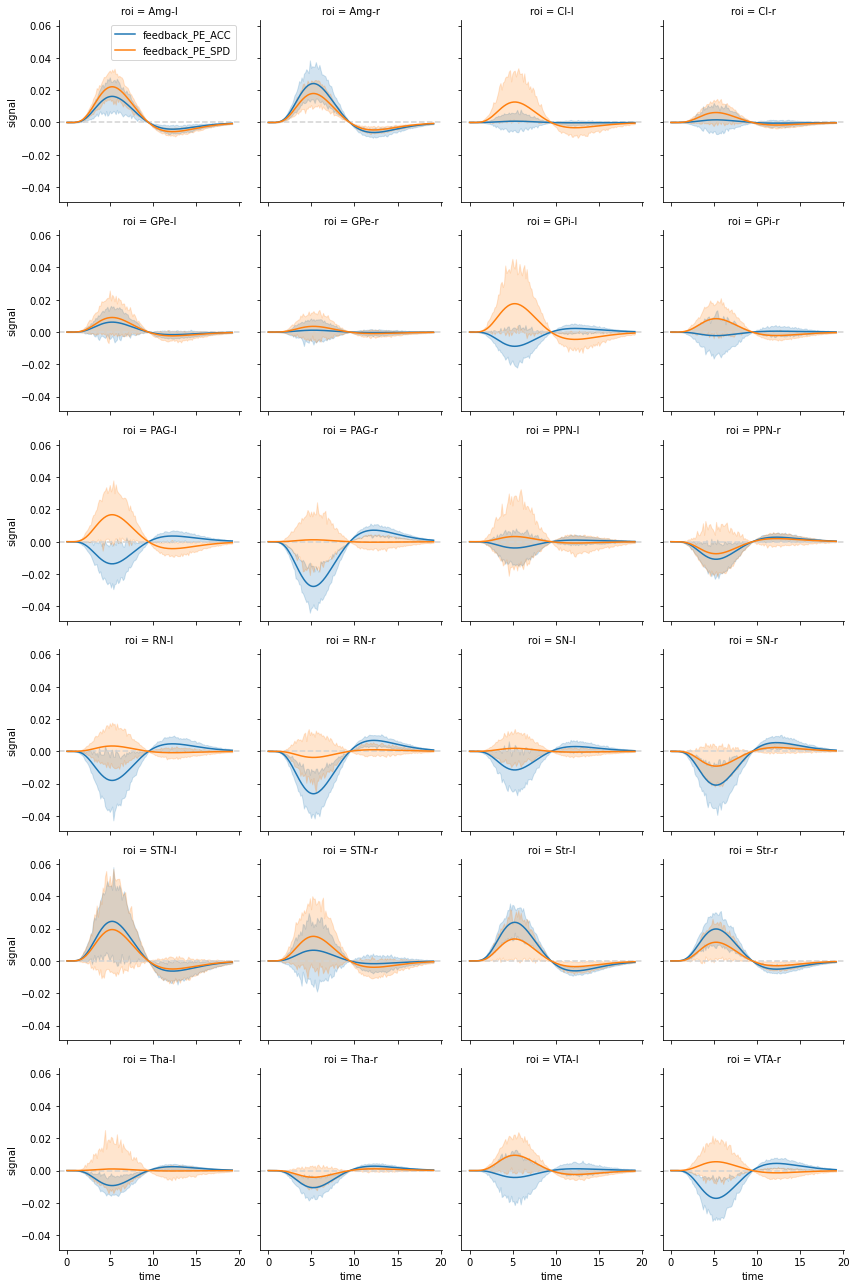

In [136]:
tc = glm2.get_subjectwise_timecourses()
tc = tc.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')
g = sns.FacetGrid(col='roi', data=tc.loc[(tc['event type'].isin(include_events)) & (tc['covariate'] == 'modulation')], col_wrap=4, hue='event type')

for ax in g.axes.ravel():
    ax.axhline(0, color='lightgray', linestyle='--')
g.map(sns.lineplot, 'time', 'signal', n_boot=100)
g.axes.ravel()[0].legend()